In [144]:
import sys 
sys.path.append('..')
from common.config import ConfigTrain as ct
from common.utils_train import sensors
from common.utils_train import header

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import warnings

#modeling part
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier


from scipy.stats import randint

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format',  '{:,}'.format)



def read_in(file1, file2, file3, file4):
    df1 = pd.read_csv(file1, sep = " ", header = 0, names = header)
    df1['dataset'] = "FD001"
    df2 = pd.read_csv(file2, sep = " ", header = 0, names = header)
    df2['dataset'] = "FD002"
    df3 = pd.read_csv(file3, sep = " ", header = 0, names = header)
    df3['dataset'] = "FD003"
    df4 = pd.read_csv(file4, sep = " ", header = 0, names = header)
    df4['dataset'] = "FD004"
    return df1, df2, df3, df4

def concatenation(df1, df2, df3, df4):
    train = pd.concat([df1, df2, df3, df4], ignore_index=True)
    train = train.drop(["blank1", "blank2"], axis = 1)
    return train


def remining_cycles(train):
    maxi_df = pd.DataFrame(train.groupby(["esn", "dataset"])["cycles"].max().reset_index())
    maxi_df.rename(columns = {"cycles" : "max_cycles"}, inplace = True)
    train = train.merge(maxi_df, how = "left", on = ["esn", "dataset"])
    train['rem_cycles'] = train['cycles'] - train['max_cycles']
    return train

n_clusters = 6
def clustering(train):
    kmeans = KMeans(n_clusters = n_clusters, 
                    random_state = 0, 
                    n_init="auto").fit(train[["opset1","opset2"]].to_numpy())
    train["condition"] = kmeans.labels_
    return train

lead_time = -100

In [68]:
df1, df2, df3, df4 = read_in(ct.location1, ct.location2, ct.location3, ct.location4)

In [145]:
train = concatenation(df1, df2, df3, df4)
train = remining_cycles(train)
train = clustering(train)


In [79]:
train.head()

esn  cycles  opset1  opset2   TRA     T2    T24      T30      T50    P2  \
0    1       2  0.0019 -0.0003 100.0 518.67 642.15 1,591.82 1,403.14 14.62   
1    1       3 -0.0043  0.0003 100.0 518.67 642.35 1,587.99  1,404.2 14.62   
2    1       4  0.0007     0.0 100.0 518.67 642.35 1,582.79 1,401.87 14.62   
3    1       5 -0.0019 -0.0002 100.0 518.67 642.37 1,582.85 1,406.22 14.62   
4    1       6 -0.0043 -0.0001 100.0 518.67  642.1 1,584.47 1,398.37 14.62   

    P15    P30       Nf       Nc  epr  Ps30    phi      NRf      NRc    BPR  \
0 21.61 553.75 2,388.04 9,044.07  1.3 47.49 522.28 2,388.07 8,131.49 8.4318   
1 21.61 554.26 2,388.08 9,052.94  1.3 47.27 522.42 2,388.03 8,133.23 8.4178   
2 21.61 554.45 2,388.11 9,049.48  1.3 47.13 522.86 2,388.08 8,133.83 8.3682   
3 21.61  554.0 2,388.06 9,055.15  1.3 47.28 522.19 2,388.04  8,133.8 8.4294   
4 21.61 554.67 2,388.02 9,049.68  1.3 47.16 521.68 2,388.03 8,132.85 8.4108   

   farB  htBleed  Nf_dmd  PCNfR_dmd   W31     W32 dataset  max_cycles  \
0  0.03      392    2388      100.0  39.0 23.4236   FD001         192   
1  0.03      390    2388      100.0 38.95 23.3442   FD001         192   
2  0.03      392    2388      100.0 38.88 23.3739   FD001         192   
3  0.03      393    2388      100.0  38.9 23.4044   FD001         192   
4  0.03      391    2388      100.0 38.98 23.3669   FD001         192   

   rem_cycles  condition  
0        -190          2  
1        -189          2  
2        -188          2  
3        -187          2  
4        -186          2

# Diagnostics

As business requirement is to know prior 100 cycles which ESN will be damaged, variable y_train ["Class"] is created where **1**: ESN is damaged, **0**: ESN is not damaged.

Classification model is to be train having y_train and only sensors and condition variables as X_train

Classification model is going to be tested aganist validation set retrieved from train set

In [146]:
def make_y(row):
    return 1 if row["rem_cycles"] > lead_time else 0

train["Class"] = train.apply(make_y, axis = 1)

In [147]:
train.head()

esn  cycles  opset1  opset2   TRA     T2    T24      T30      T50    P2  \
0    1       2  0.0019 -0.0003 100.0 518.67 642.15 1,591.82 1,403.14 14.62   
1    1       3 -0.0043  0.0003 100.0 518.67 642.35 1,587.99  1,404.2 14.62   
2    1       4  0.0007     0.0 100.0 518.67 642.35 1,582.79 1,401.87 14.62   
3    1       5 -0.0019 -0.0002 100.0 518.67 642.37 1,582.85 1,406.22 14.62   
4    1       6 -0.0043 -0.0001 100.0 518.67  642.1 1,584.47 1,398.37 14.62   

    P15    P30       Nf       Nc  epr  Ps30    phi      NRf      NRc    BPR  \
0 21.61 553.75 2,388.04 9,044.07  1.3 47.49 522.28 2,388.07 8,131.49 8.4318   
1 21.61 554.26 2,388.08 9,052.94  1.3 47.27 522.42 2,388.03 8,133.23 8.4178   
2 21.61 554.45 2,388.11 9,049.48  1.3 47.13 522.86 2,388.08 8,133.83 8.3682   
3 21.61  554.0 2,388.06 9,055.15  1.3 47.28 522.19 2,388.04  8,133.8 8.4294   
4 21.61 554.67 2,388.02 9,049.68  1.3 47.16 521.68 2,388.03 8,132.85 8.4108   

   farB  htBleed  Nf_dmd  PCNfR_dmd   W31     W32 dataset  max_cycles  \
0  0.03      392    2388      100.0  39.0 23.4236   FD001         192   
1  0.03      390    2388      100.0 38.95 23.3442   FD001         192   
2  0.03      392    2388      100.0 38.88 23.3739   FD001         192   
3  0.03      393    2388      100.0  38.9 23.4044   FD001         192   
4  0.03      391    2388      100.0 38.98 23.3669   FD001         192   

   rem_cycles  condition  Class  
0        -190          2      0  
1        -189          2      0  
2        -188          2      0  
3        -187          2      0  
4        -186          2      0

### Feature Selection

On basis of following visualization, sensors that are not vary will be excluded from list of predictors.
List of final predictors:
1. T24
2. T30 aka T3
3. T50
4. P30 aka P3
5. Nc
6. epr
7. Ps30
8. phi
9. NRc
10. BPR
11. htBleed
12. W31
13. W32
14. condition
15. dataset

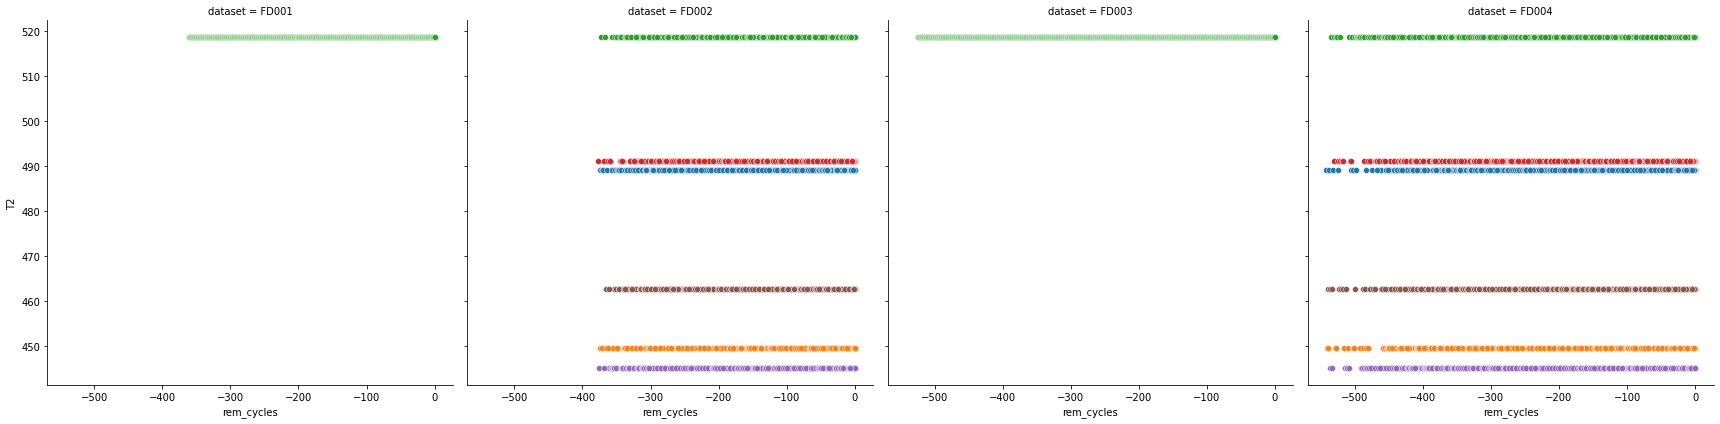

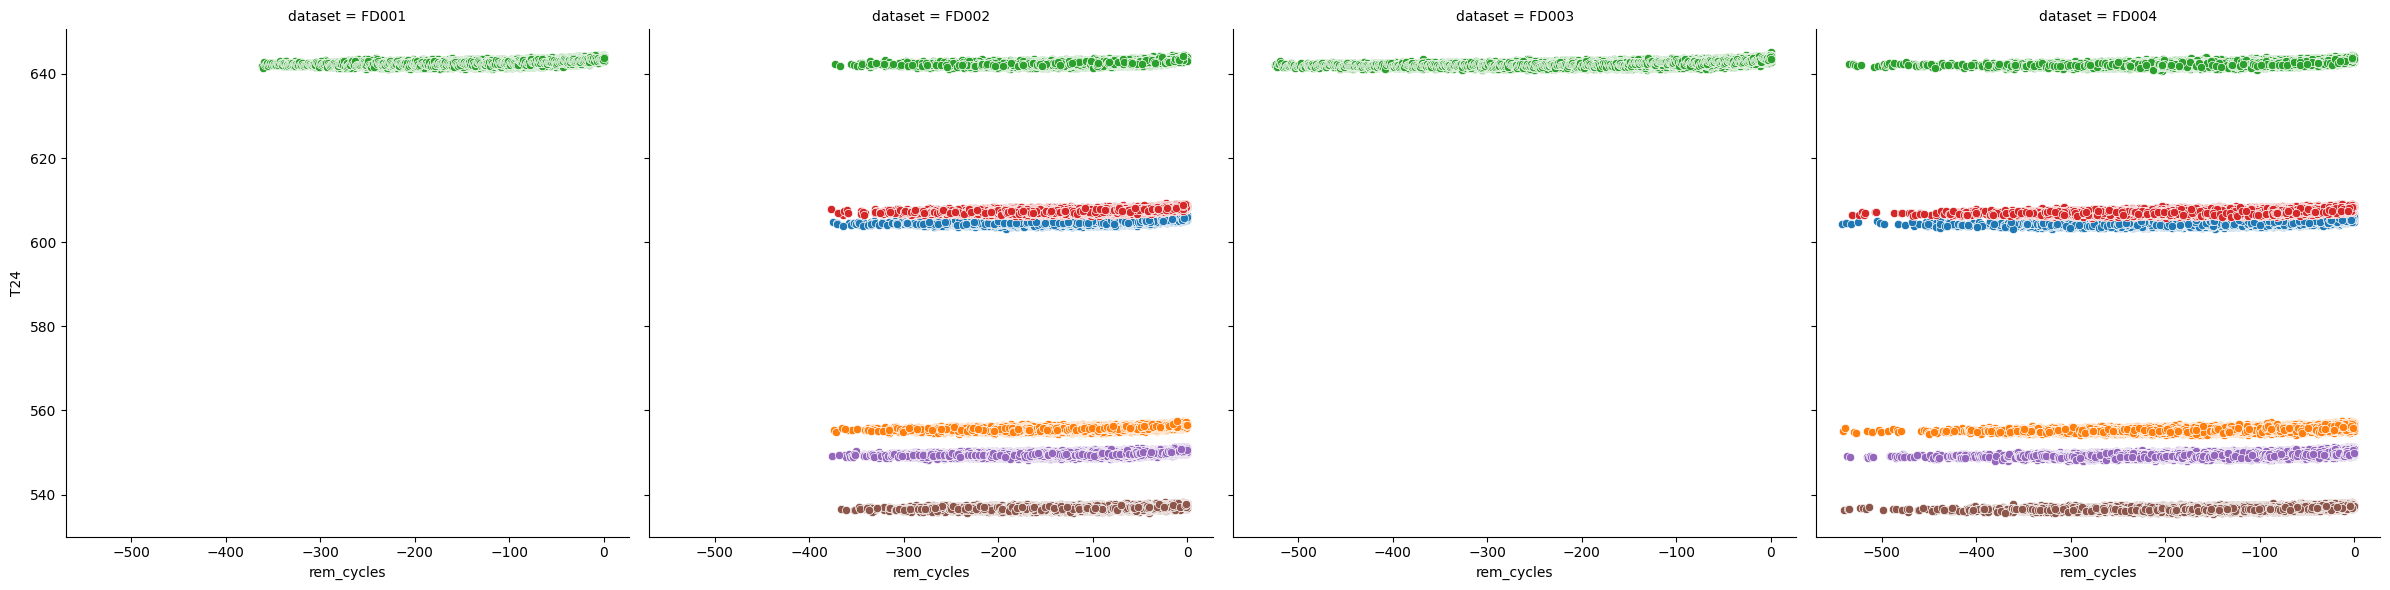

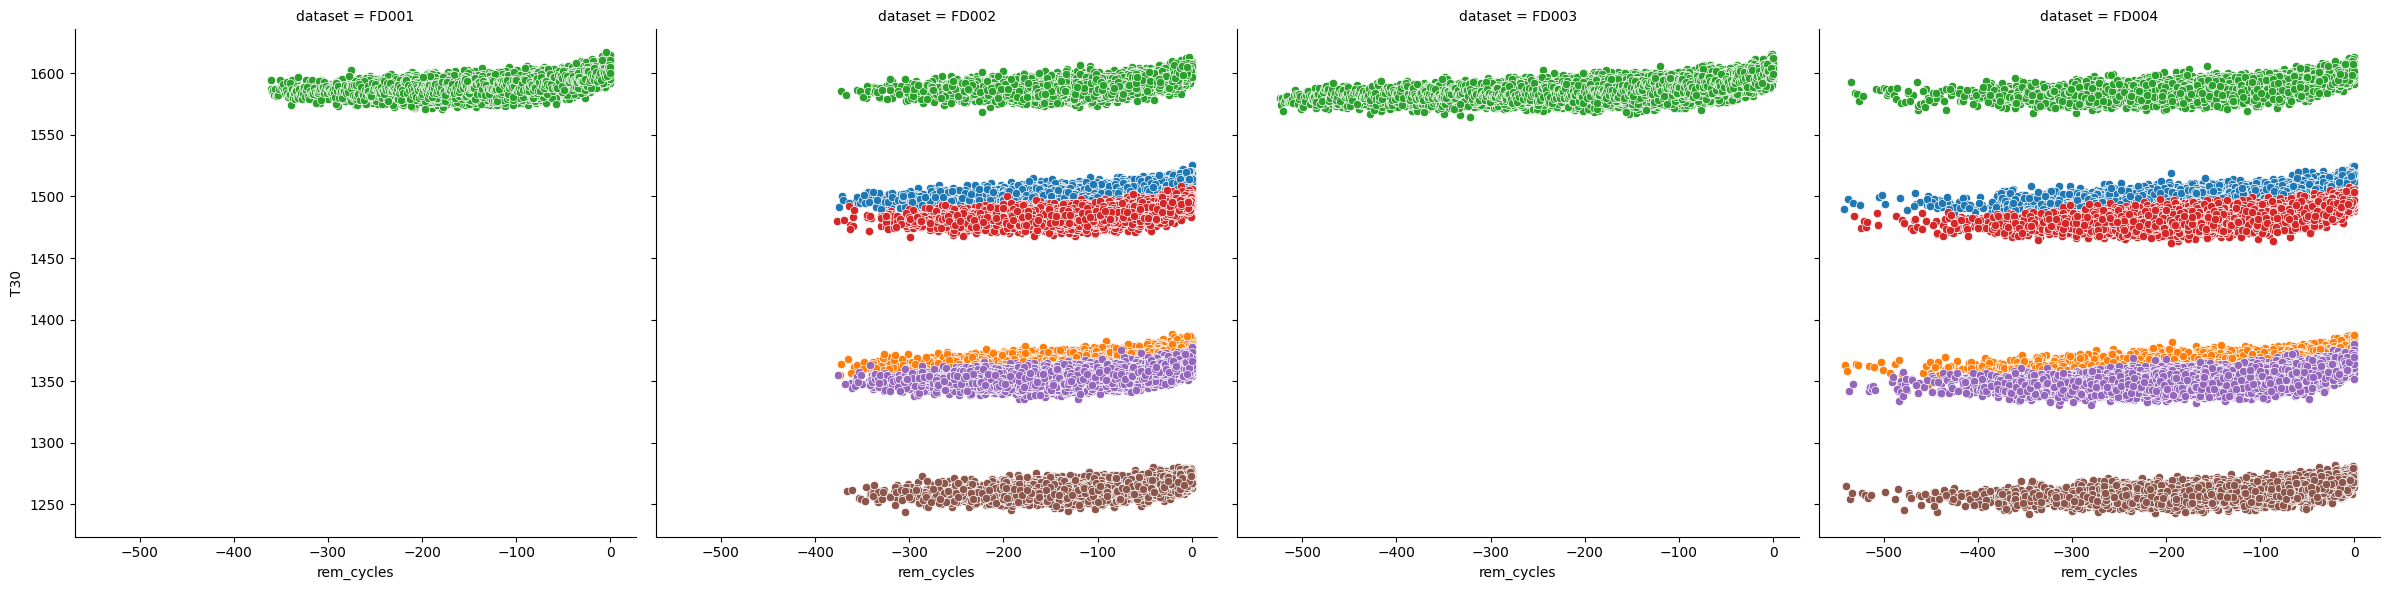

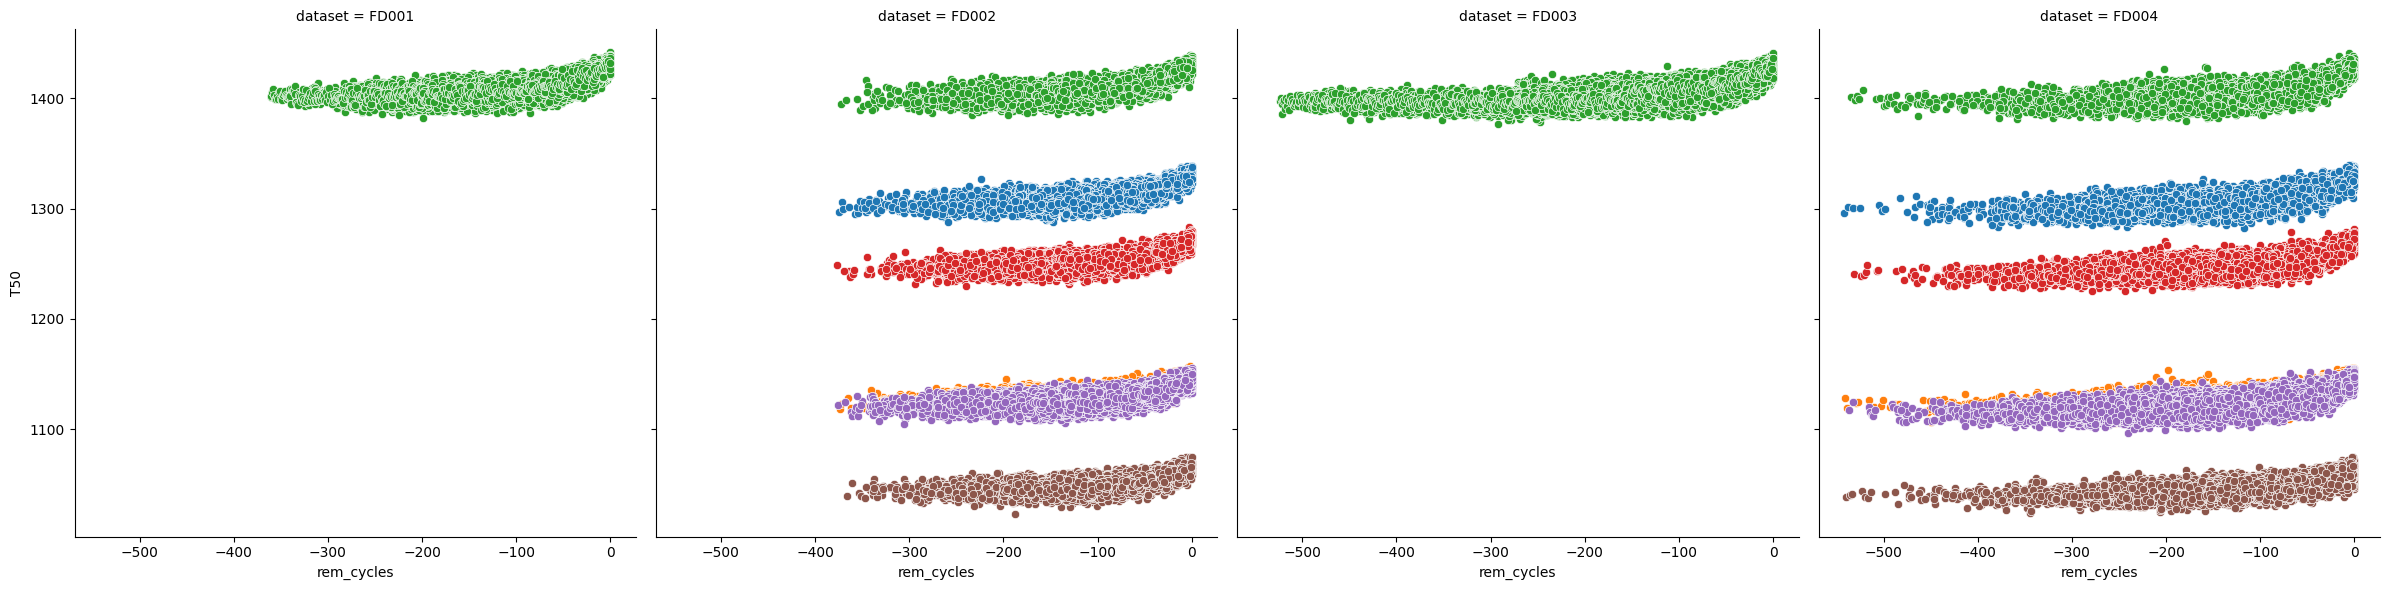

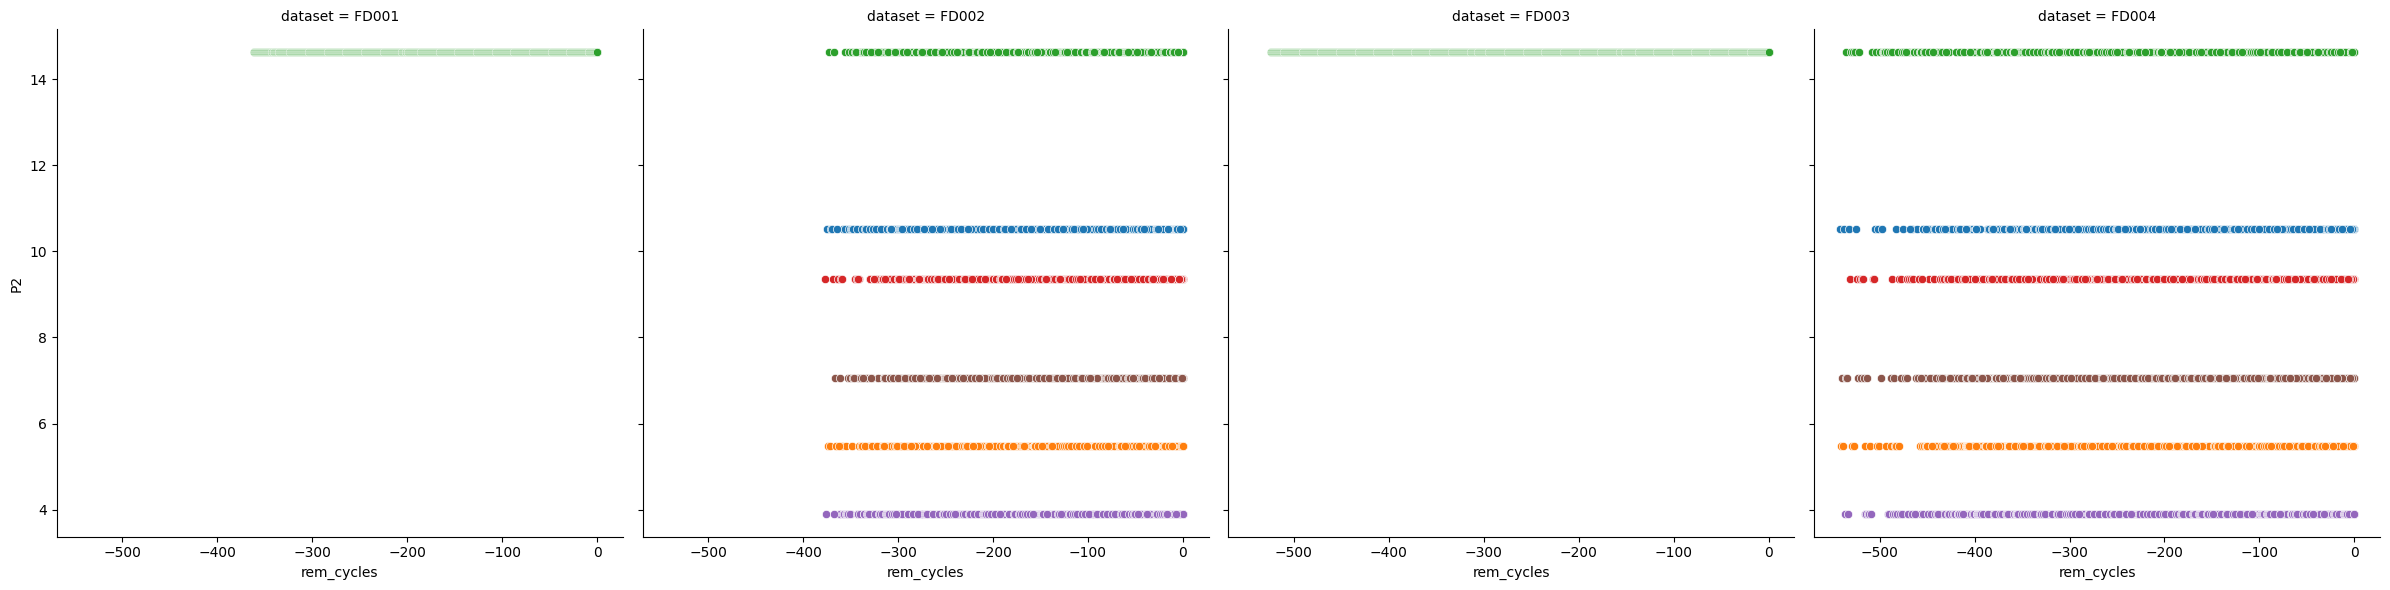

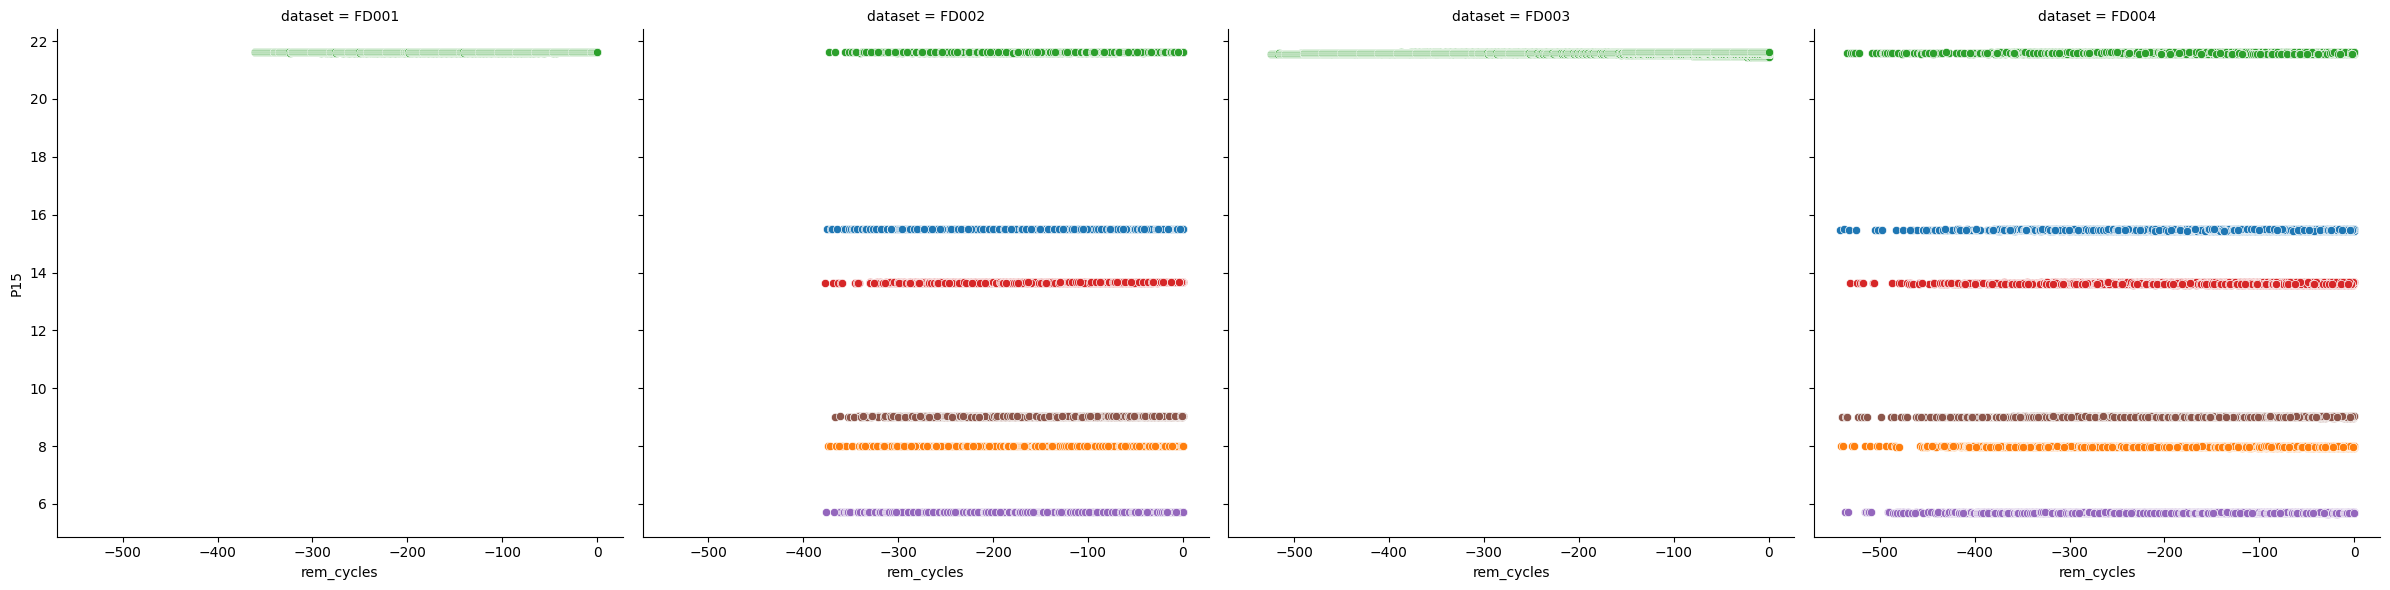

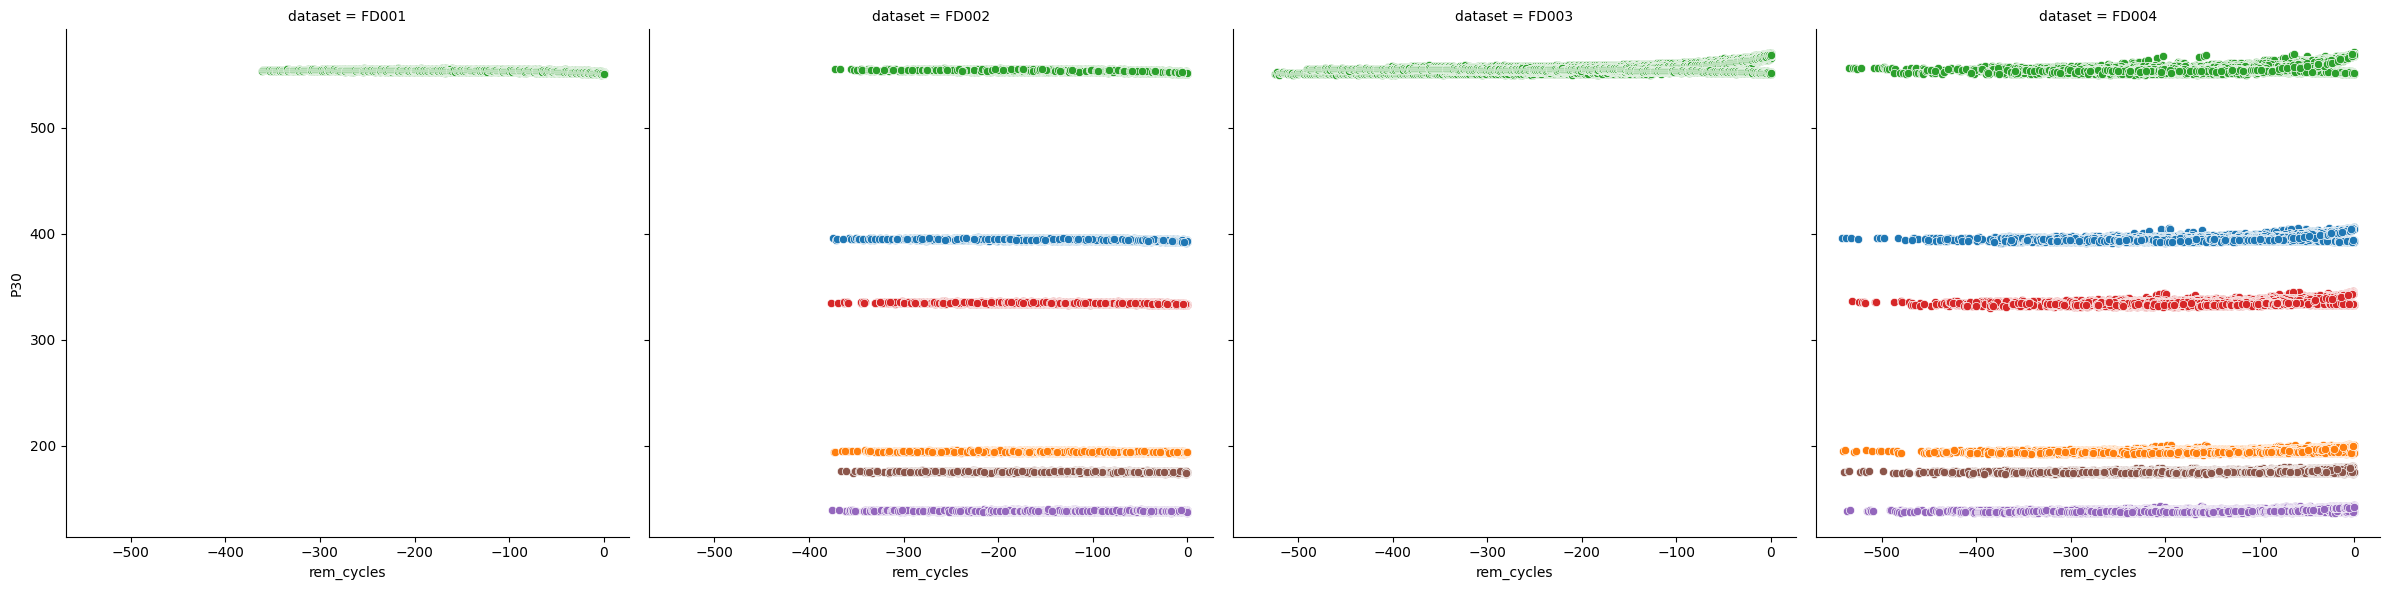

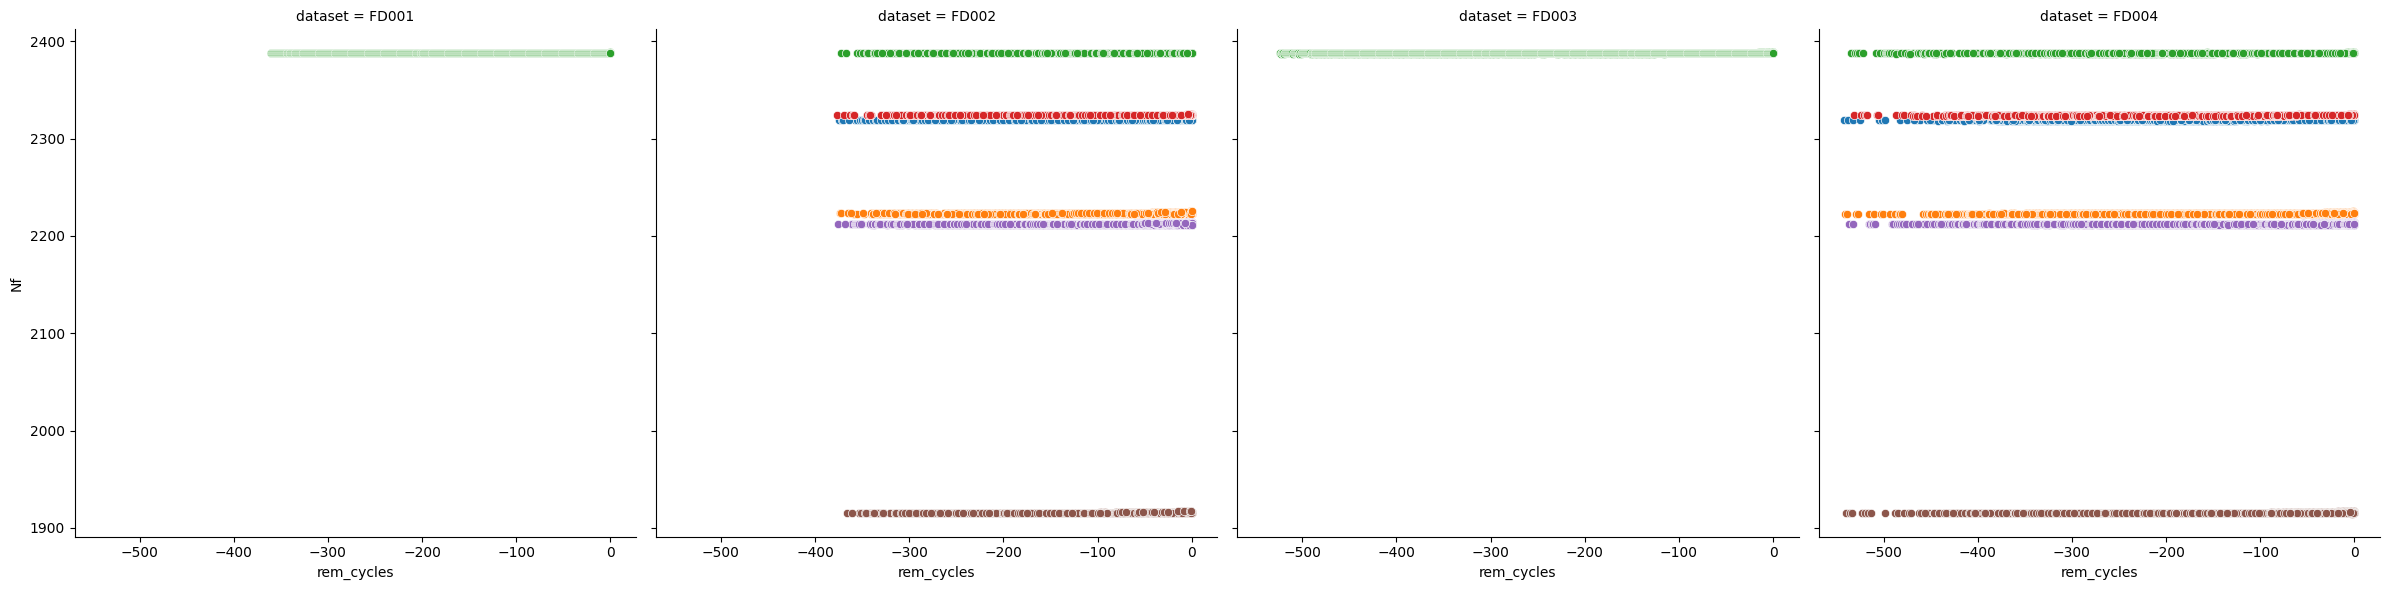

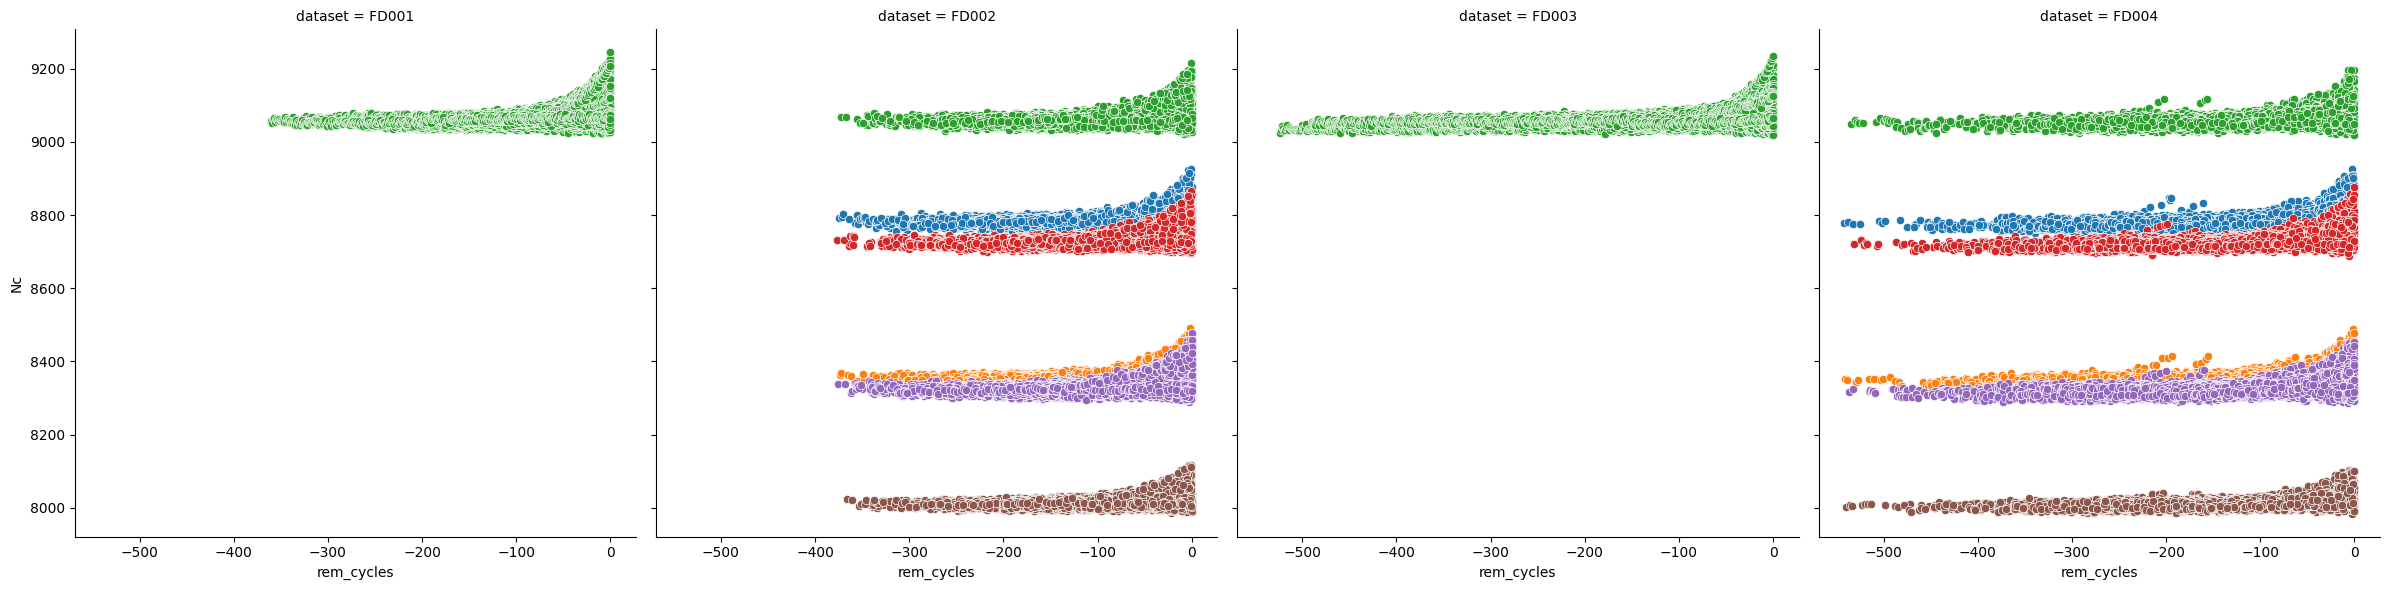

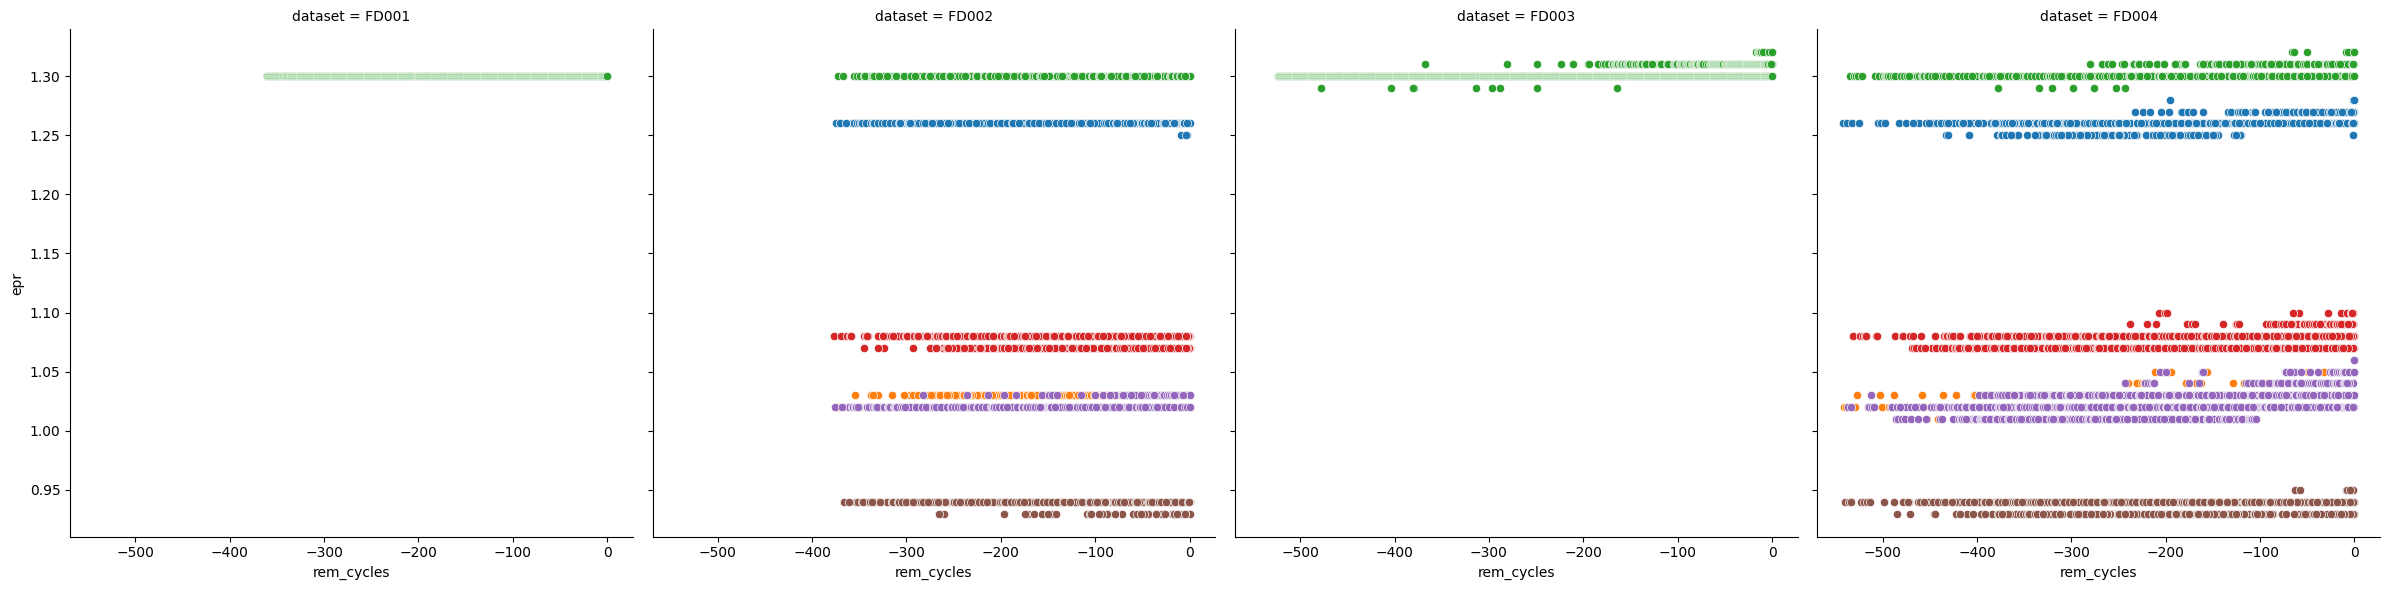

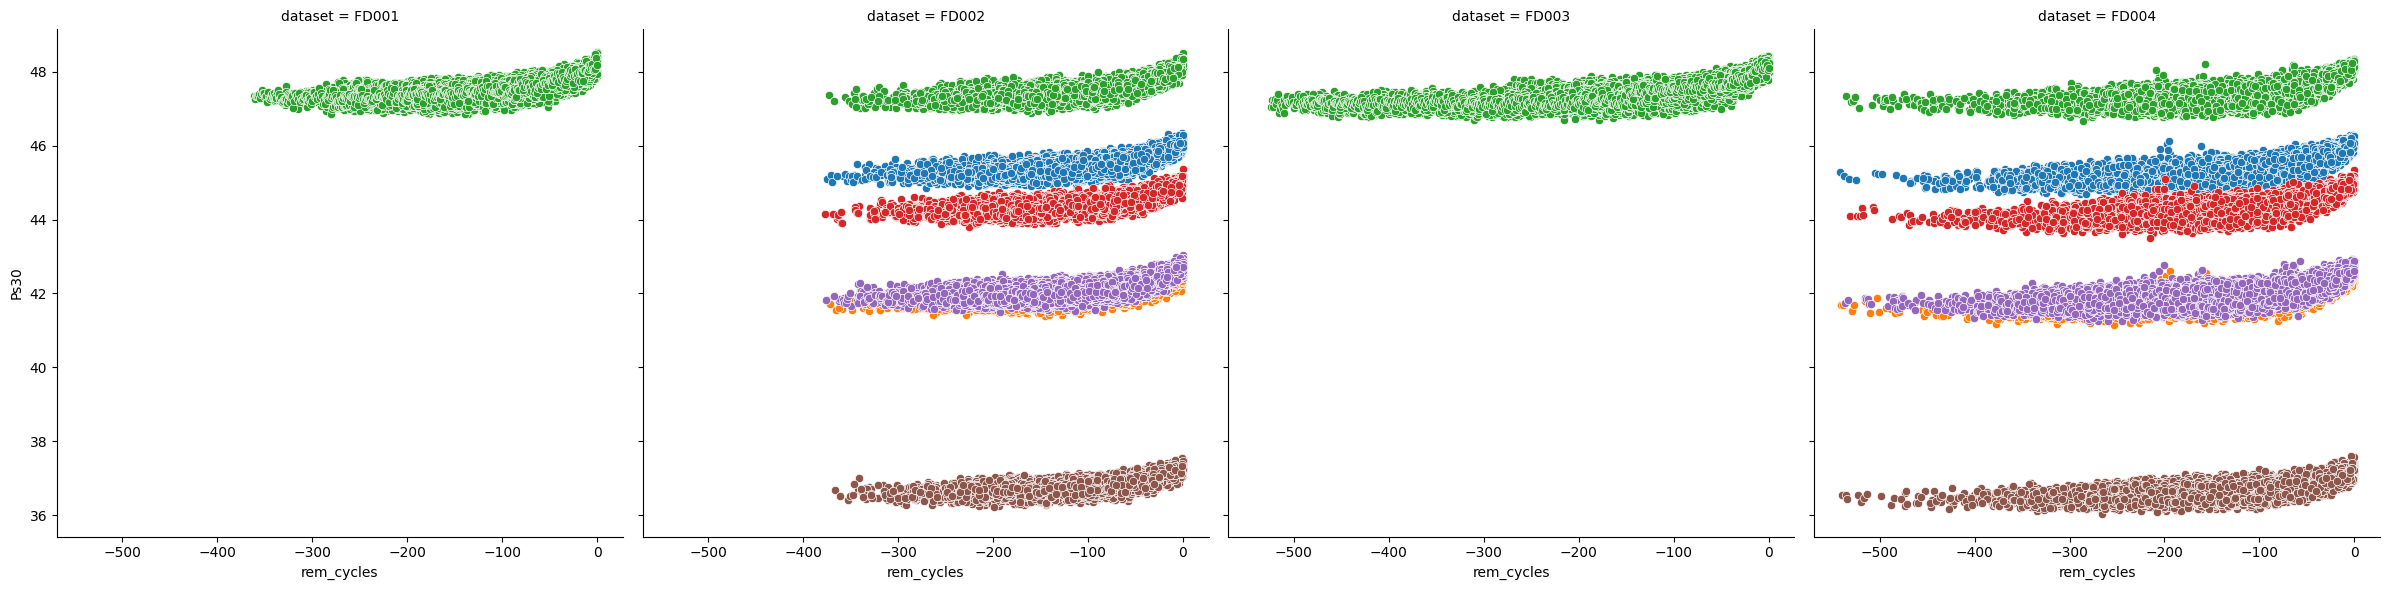

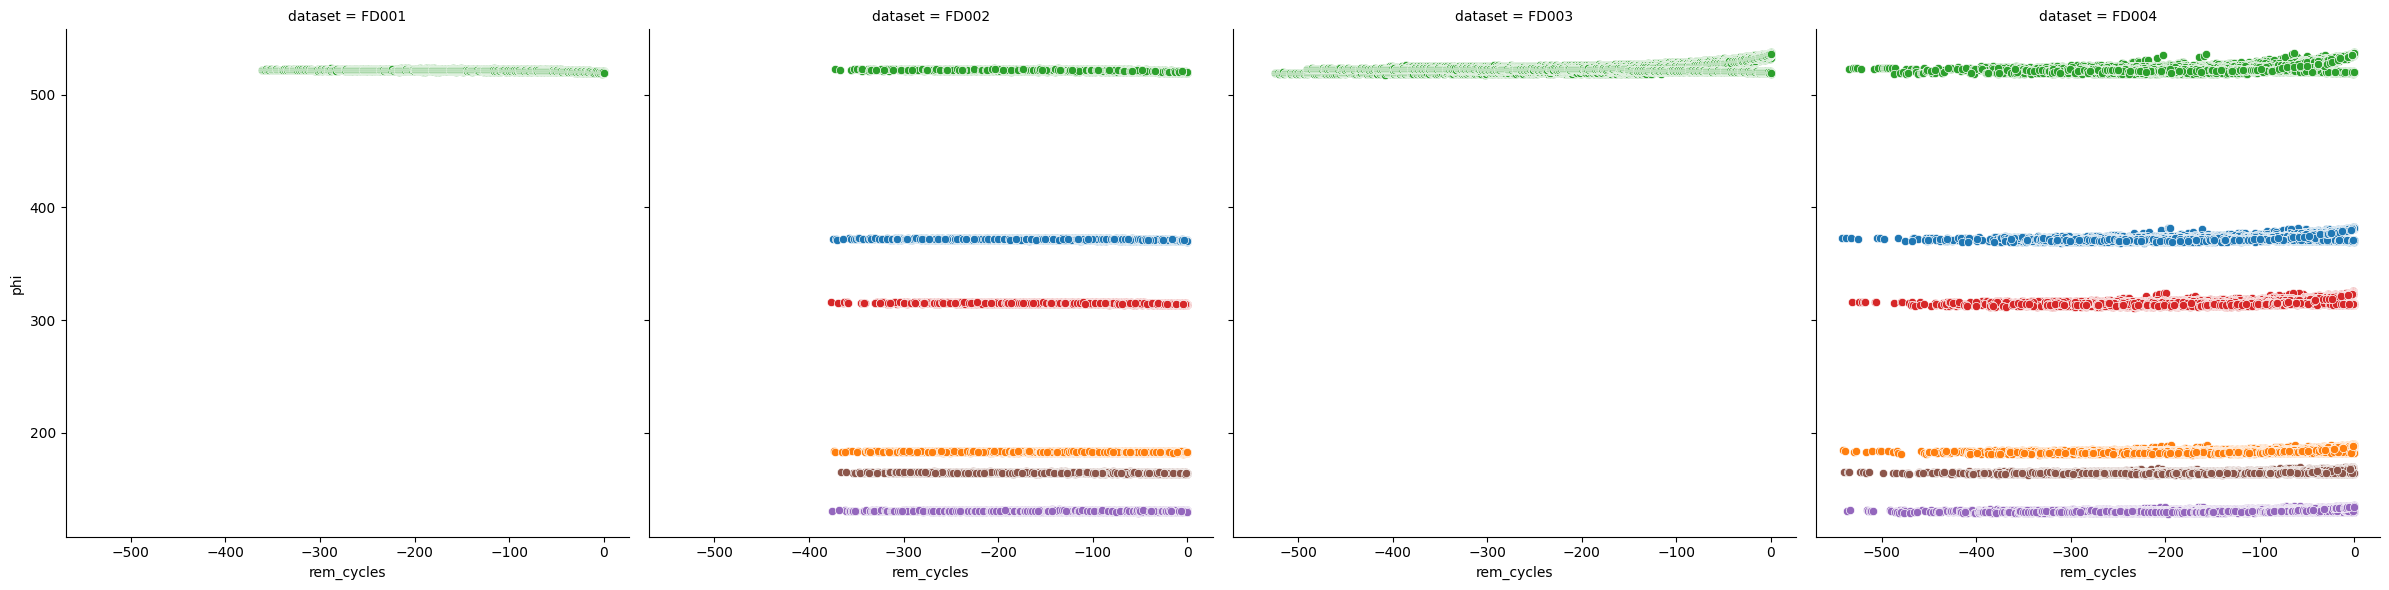

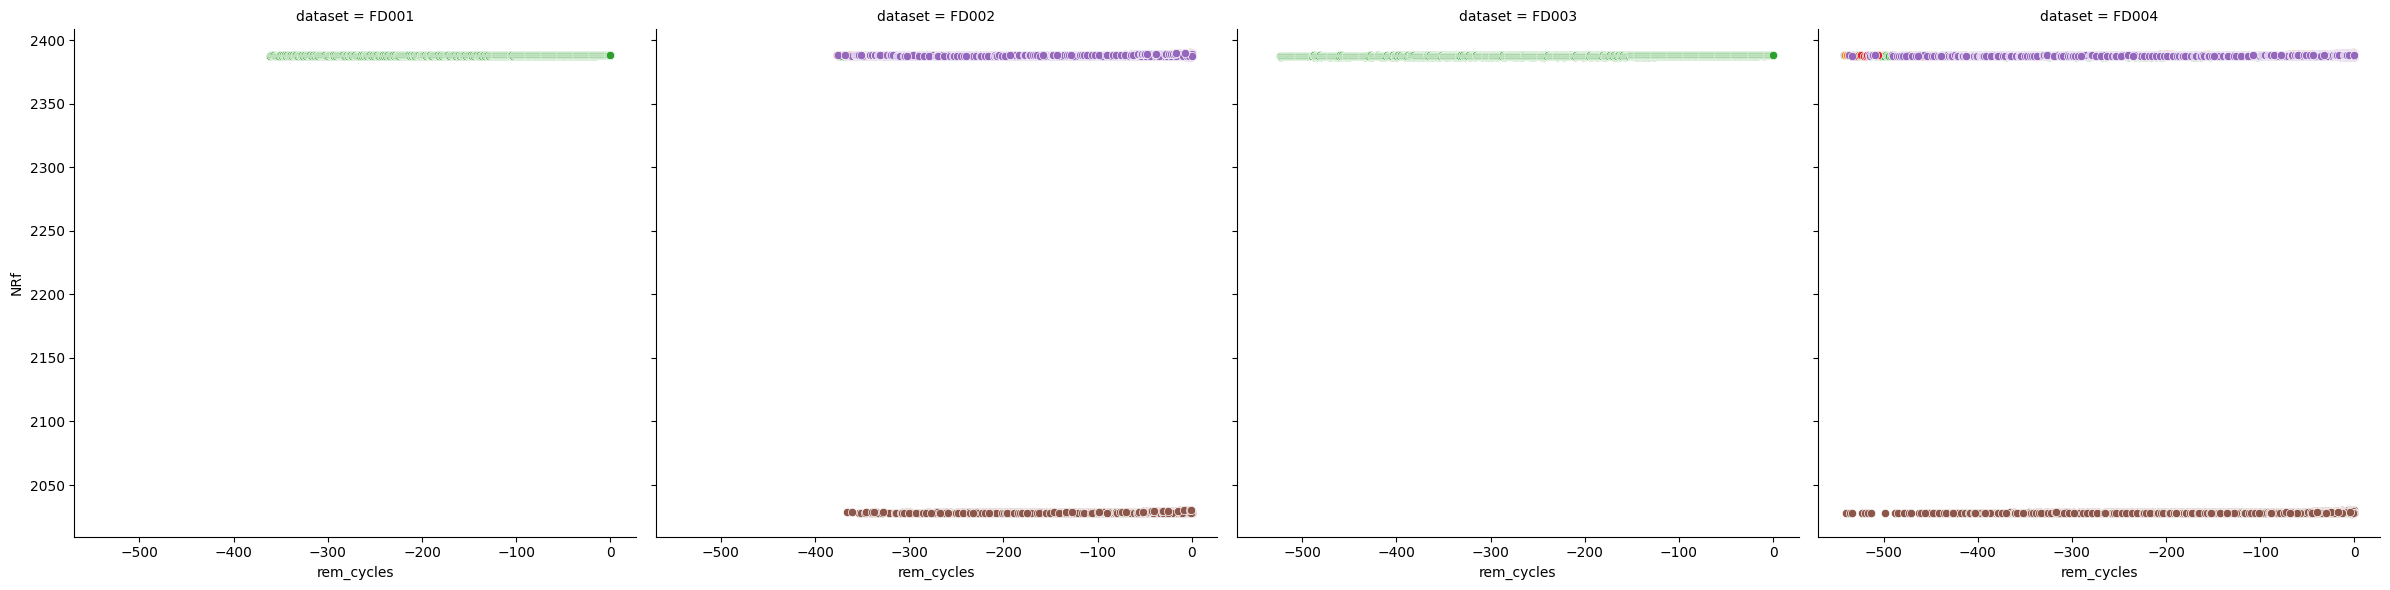

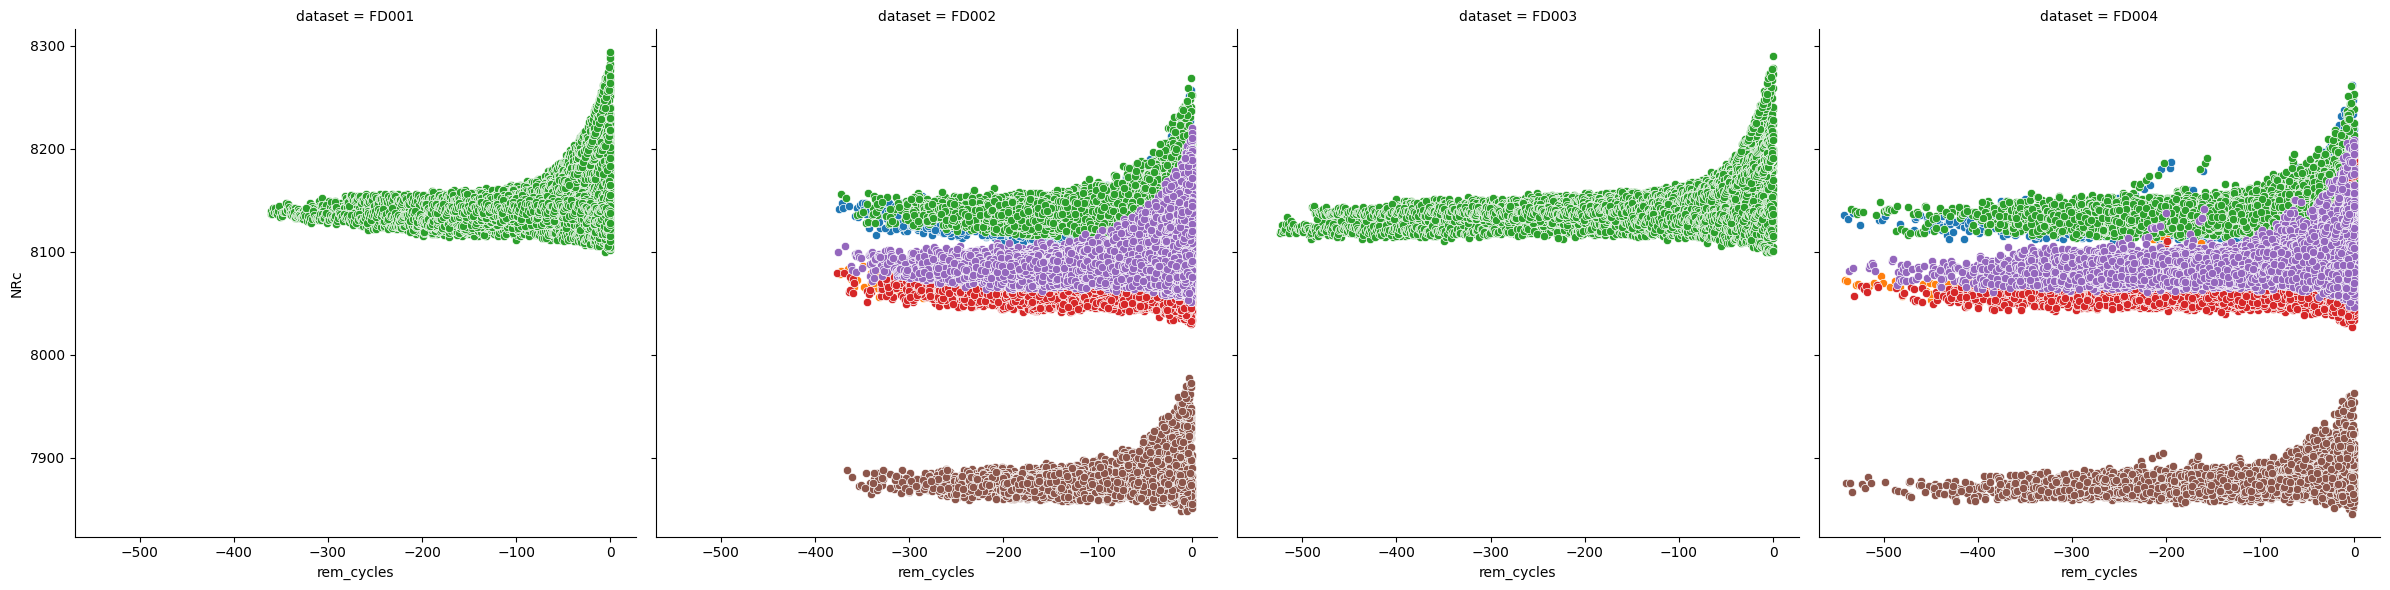

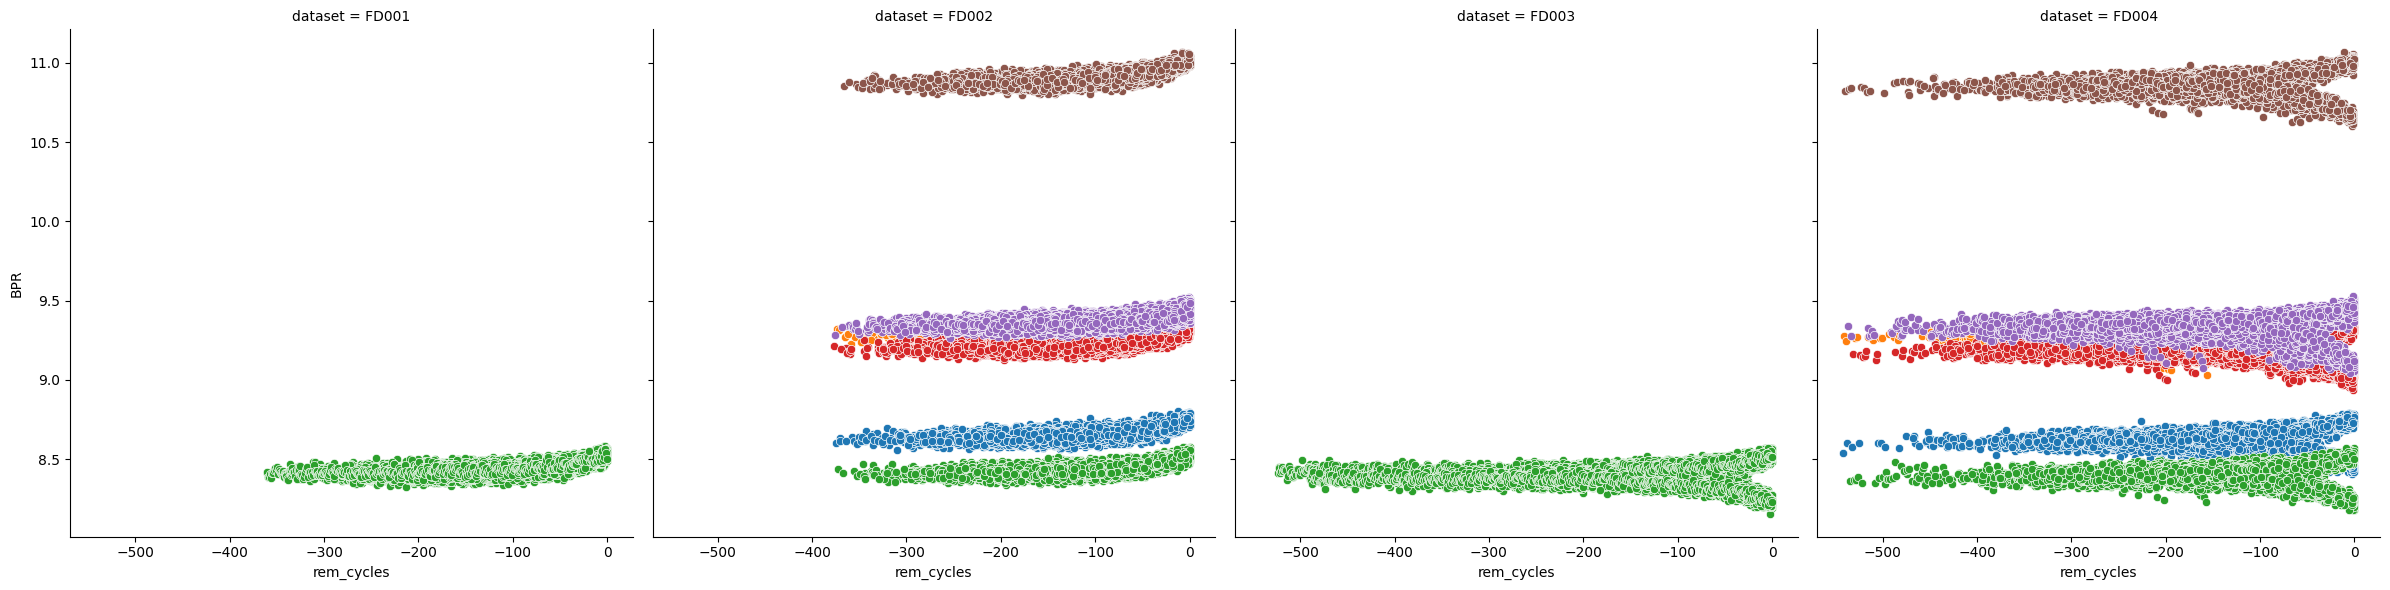

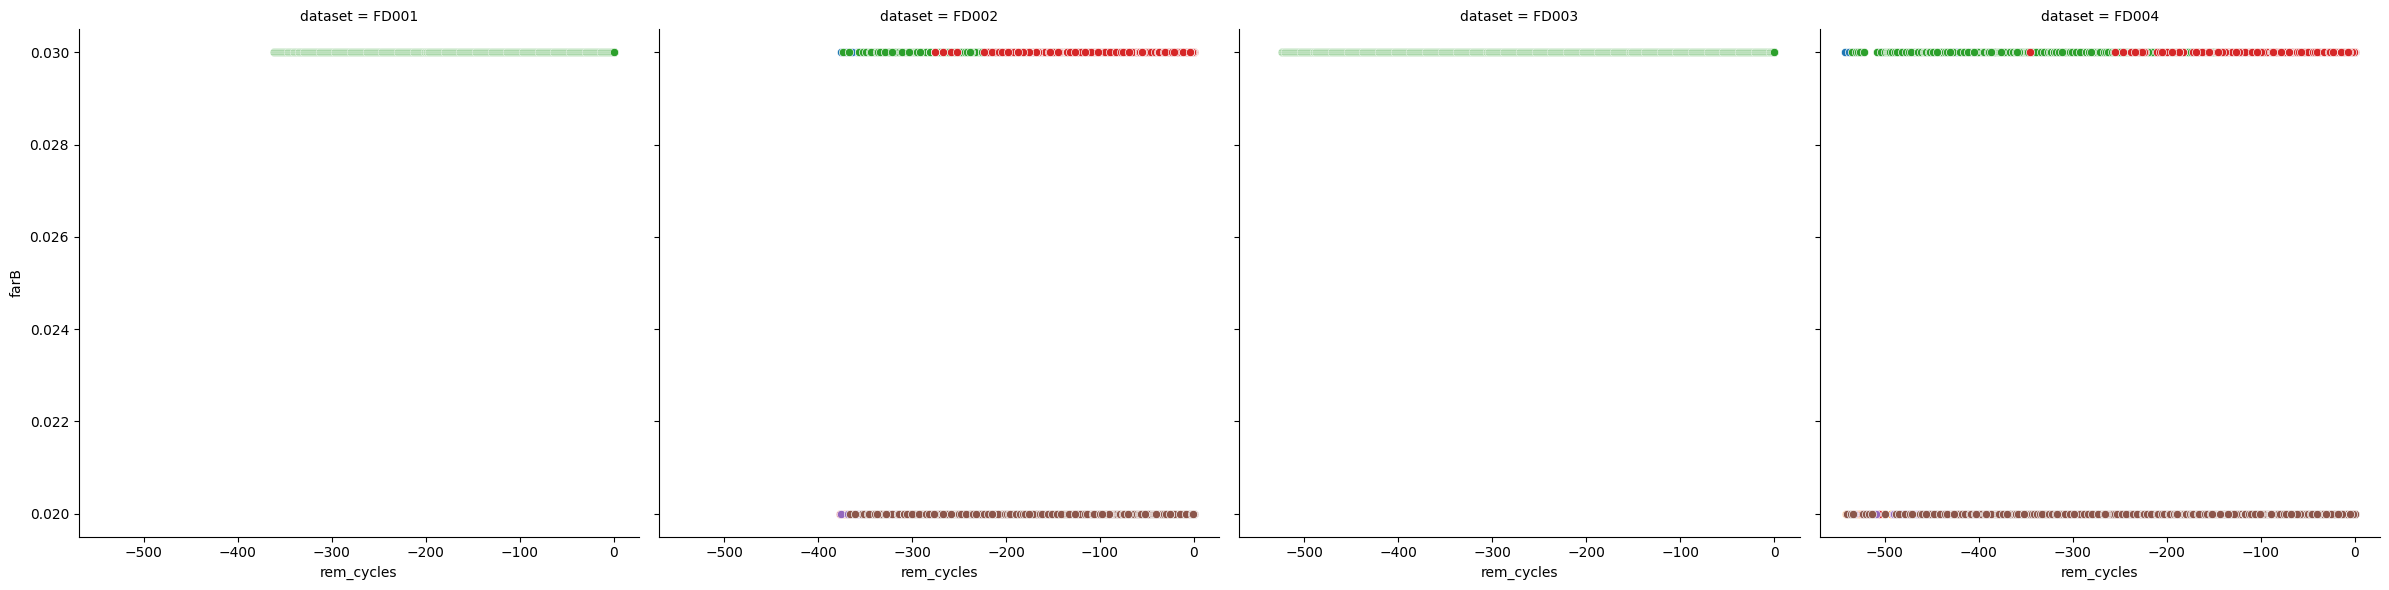

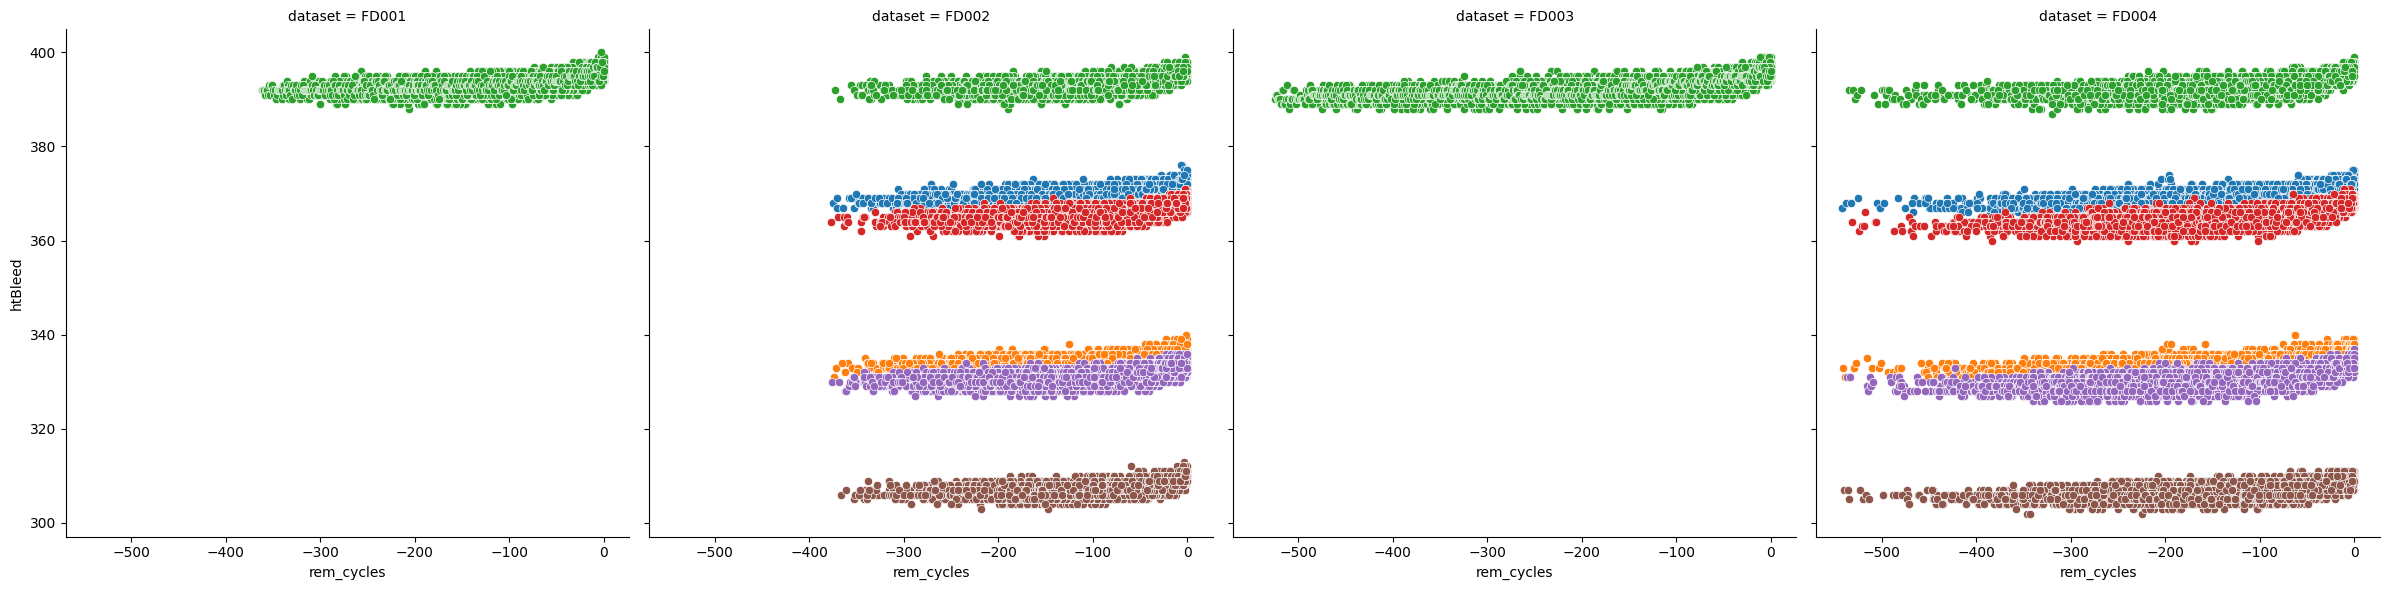

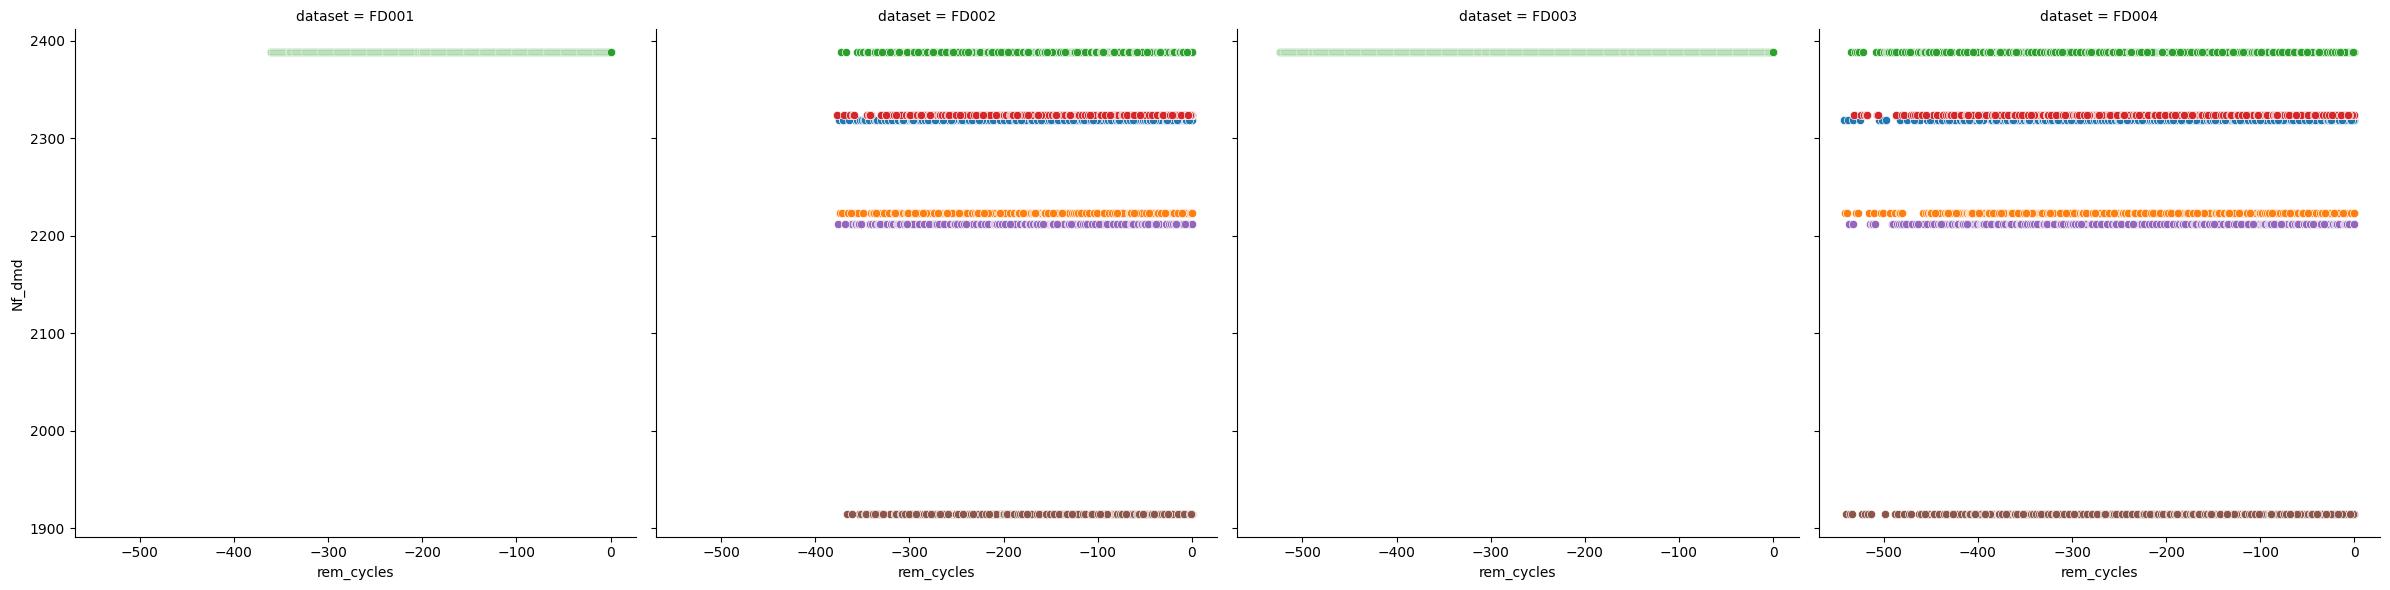

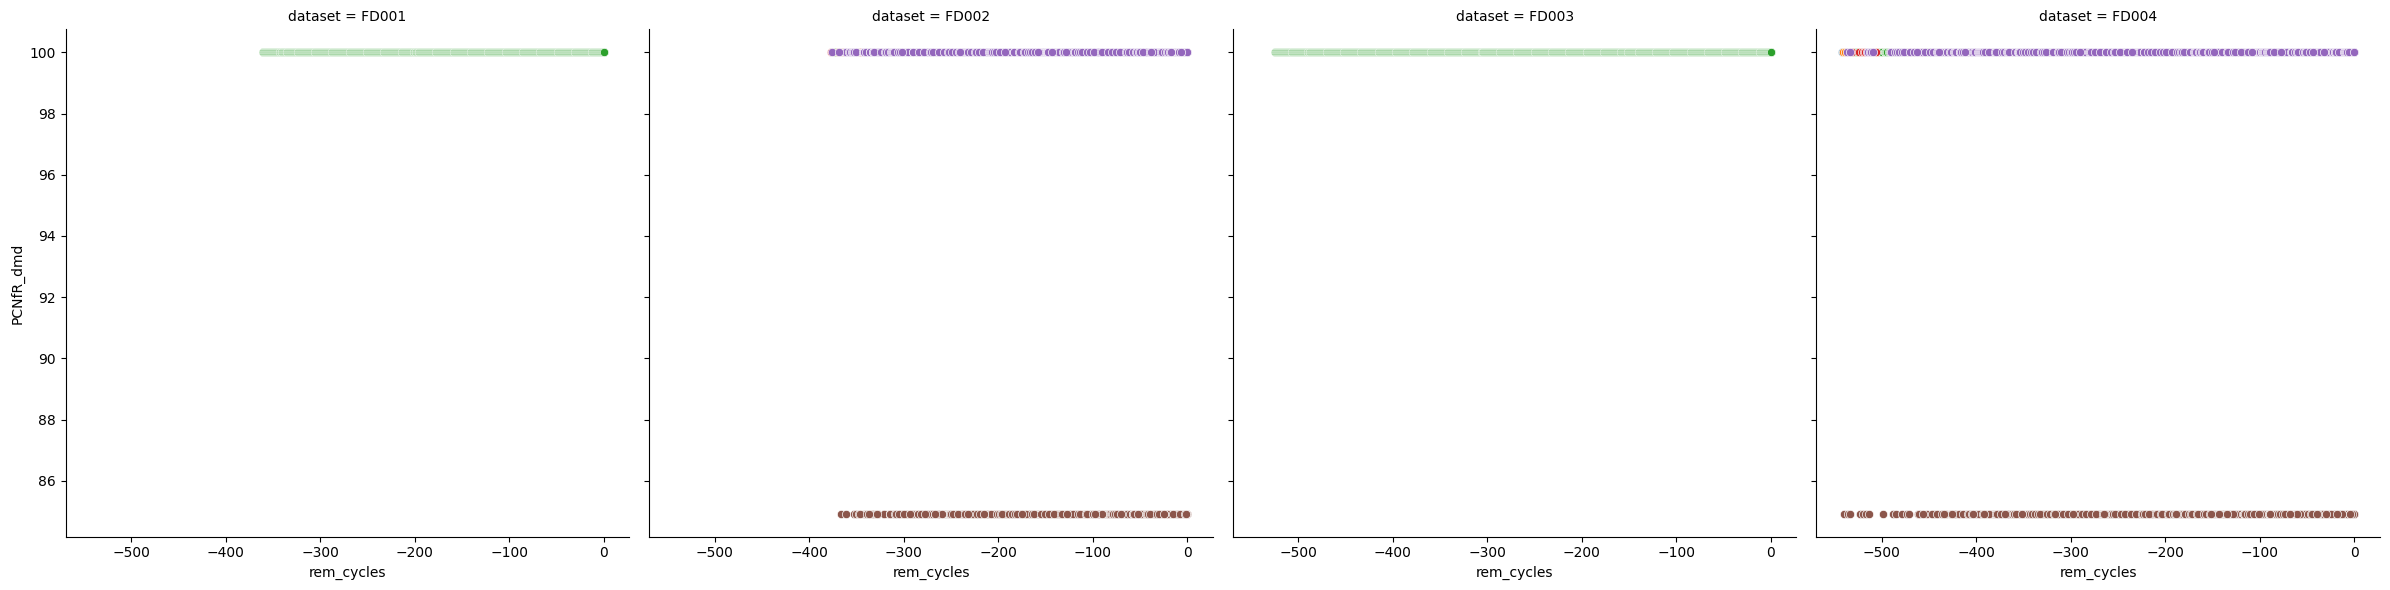

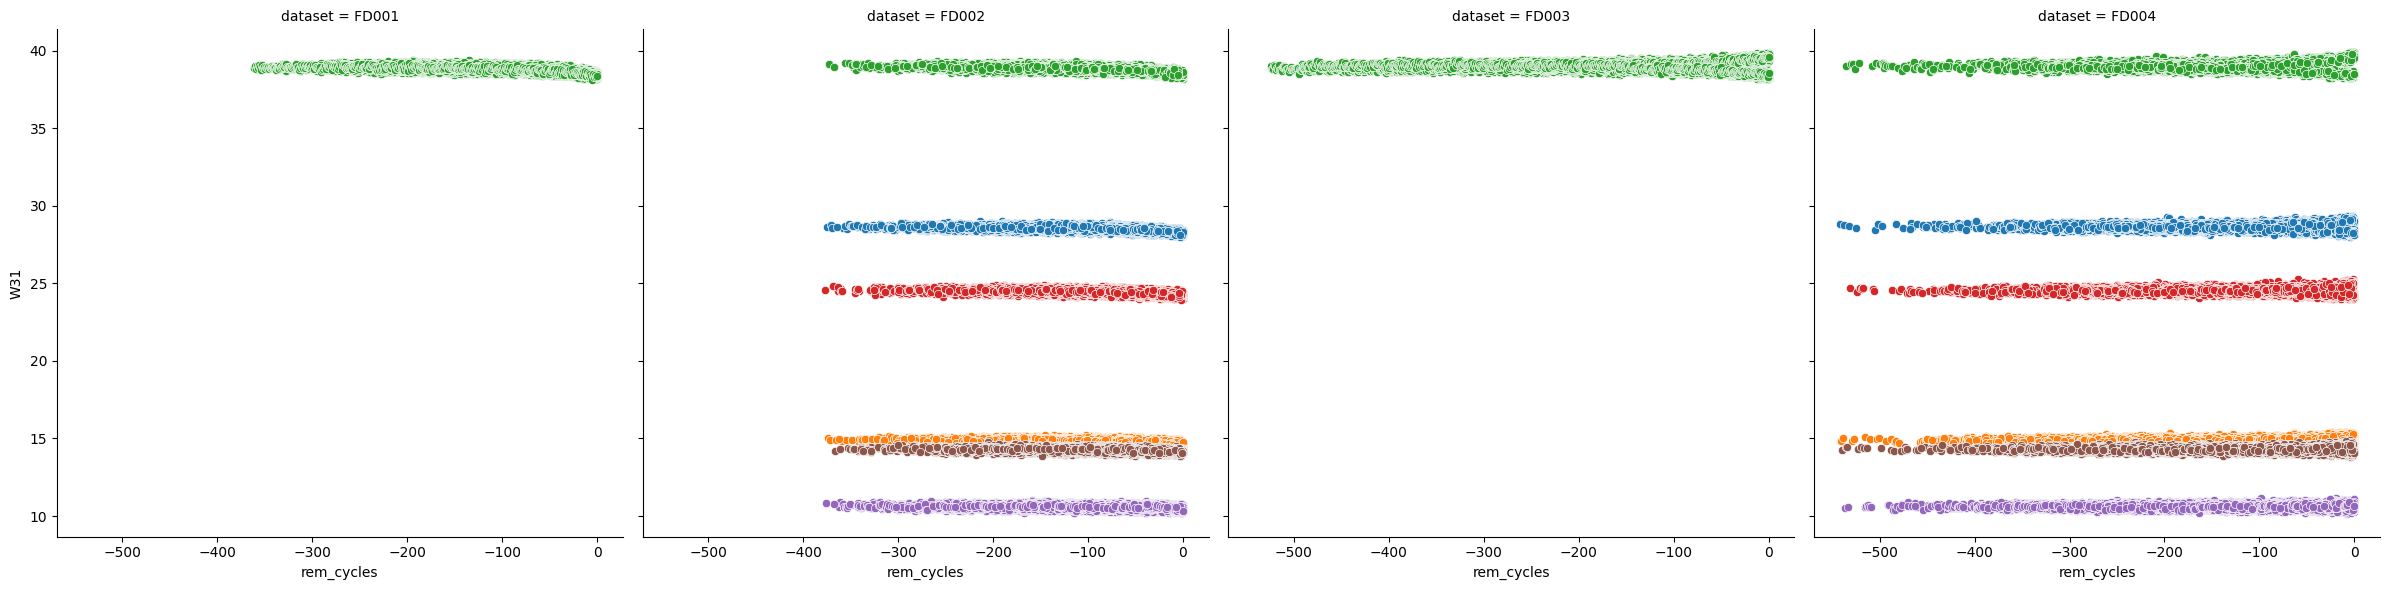

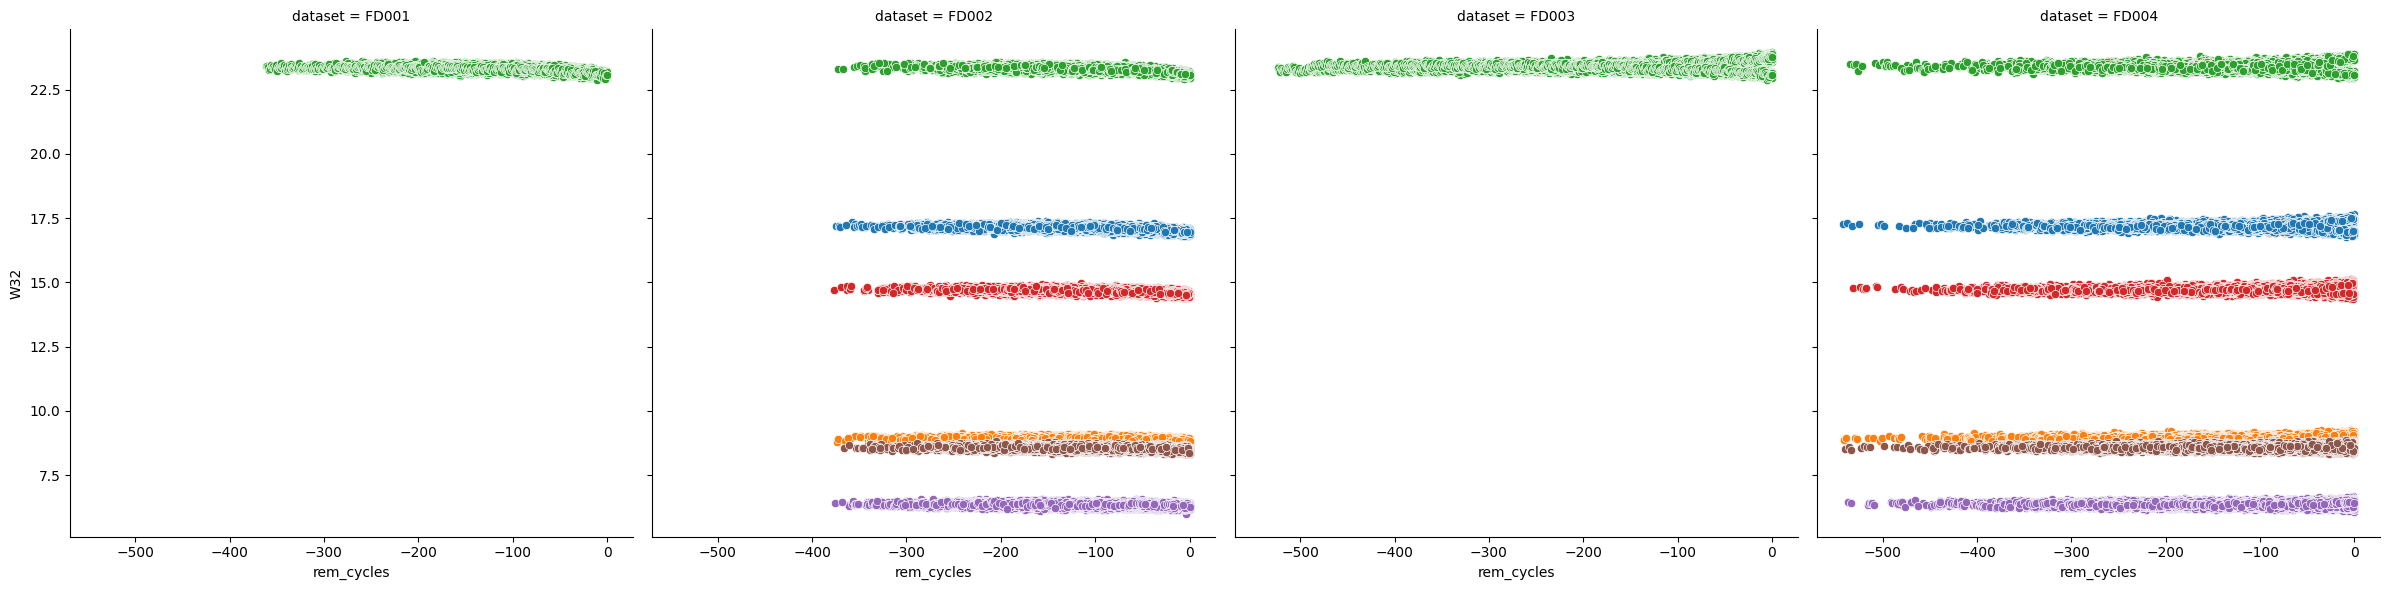

In [15]:
for sensor in sensors:    
    g = sns.FacetGrid(data = train, col = "dataset", hue= "condition",size=6)
    g.map(sns.scatterplot, "rem_cycles", sensor)
    plt.show()

One Hot Encoding for categorical variables: **DataSet** and **Category**

In [88]:

def one_hot(df, column, names=None):
    enc = OneHotEncoder()
    labelenc = LabelEncoder()
    if names == None:
        names = df[column].unique().tolist()
    df['column_cat'] = labelenc.fit_transform(df[column])
    enc_df = pd.DataFrame(enc.fit_transform(df[column].to_numpy().reshape(-1,1)).toarray(), columns = names)
    enc_df.drop(columns = names[0], inplace = True)
    df = pd.concat([df, enc_df], axis = 1)
    df.drop(columns = column, inplace = True)
    df.drop(columns = 'column_cat', inplace = True)
    return df


In [93]:
train = one_hot(train, 'dataset', ['FD001', 'FD002', 'FD003', 'FD004'])
train = one_hot(train, 'condition', ["c1","c2","c3","c4","c5","c6"])

In [94]:
train.head()

esn  cycles  opset1  opset2   TRA     T2    T24      T30      T50    P2  \
0    1       2  0.0019 -0.0003 100.0 518.67 642.15 1,591.82 1,403.14 14.62   
1    1       3 -0.0043  0.0003 100.0 518.67 642.35 1,587.99  1,404.2 14.62   
2    1       4  0.0007     0.0 100.0 518.67 642.35 1,582.79 1,401.87 14.62   
3    1       5 -0.0019 -0.0002 100.0 518.67 642.37 1,582.85 1,406.22 14.62   
4    1       6 -0.0043 -0.0001 100.0 518.67  642.1 1,584.47 1,398.37 14.62   

    P15    P30       Nf       Nc  epr  Ps30    phi      NRf      NRc    BPR  \
0 21.61 553.75 2,388.04 9,044.07  1.3 47.49 522.28 2,388.07 8,131.49 8.4318   
1 21.61 554.26 2,388.08 9,052.94  1.3 47.27 522.42 2,388.03 8,133.23 8.4178   
2 21.61 554.45 2,388.11 9,049.48  1.3 47.13 522.86 2,388.08 8,133.83 8.3682   
3 21.61  554.0 2,388.06 9,055.15  1.3 47.28 522.19 2,388.04  8,133.8 8.4294   
4 21.61 554.67 2,388.02 9,049.68  1.3 47.16 521.68 2,388.03 8,132.85 8.4108   

   farB  htBleed  Nf_dmd  PCNfR_dmd   W31     W32  max_cycles  rem_cycles  \
0  0.03      392    2388      100.0  39.0 23.4236         192        -190   
1  0.03      390    2388      100.0 38.95 23.3442         192        -189   
2  0.03      392    2388      100.0 38.88 23.3739         192        -188   
3  0.03      393    2388      100.0  38.9 23.4044         192        -187   
4  0.03      391    2388      100.0 38.98 23.3669         192        -186   

   Class  FD002  FD003  FD004  c2  c3  c4  c5  c6  
0      0    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
1      0    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
2      0    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
3      0    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0  
4      0    0.0    0.0    0.0 0.0 1.0 0.0 0.0 0.0

In [95]:
X_variables = [
    'T24',
    'T30',
    'T50',
    'P30',
    'Nc',
    'epr',
    'Ps30',
    'phi',
    'NRc',
    'BPR', #ByPass Ratio
    'htBleed',
    'W31',
    'W32',
    'FD002', # dataset
    'FD003', # dataset
    'FD004', # dataset
    'c2', # condition 2
    'c3', # condition 3
    'c4', # condition 4
    'c5', # condition 5
    'c6', # condition 6
]

In [96]:
X = train[X_variables]
y = train["Class"]

In [3]:
#X_train_vars = sensors + ["condition", "dataset"]
#X_train_vars

['T2',
 'T24',
 'T30',
 'T50',
 'P2',
 'P15',
 'P30',
 'Nf',
 'Nc',
 'epr',
 'Ps30',
 'phi',
 'NRf',
 'NRc',
 'BPR',
 'farB',
 'htBleed',
 'Nf_dmd',
 'PCNfR_dmd',
 'W31',
 'W32',
 'condition',
 'dataset']

## Train test split 

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Classification

Data are continues so following classification methods will be tested:
1. Logit
2. Decision Tree
3. Random Forest
4. LGBMClassifier
5. CatBoostClassifier

### Logistic Regression

Text(0.5, 427.9555555555555, 'Predicted label')

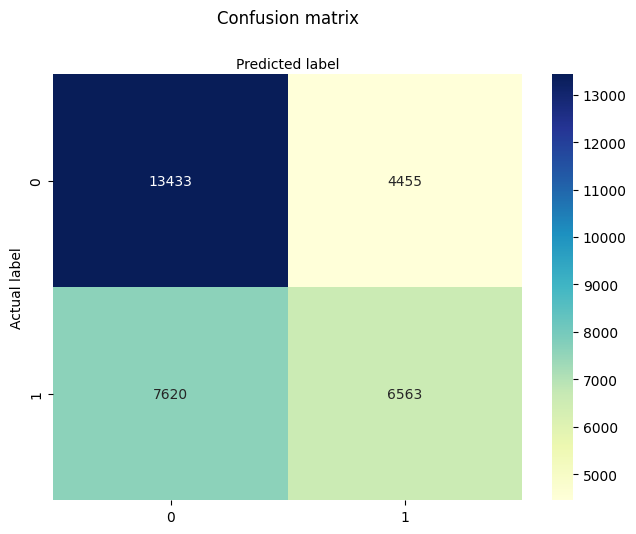

In [99]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)

cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



In [101]:
target_names = ['no damage', 'damaged']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   no damage       0.64      0.75      0.69     17888
     damaged       0.60      0.46      0.52     14183

    accuracy                           0.62     32071
   macro avg       0.62      0.61      0.61     32071
weighted avg       0.62      0.62      0.62     32071



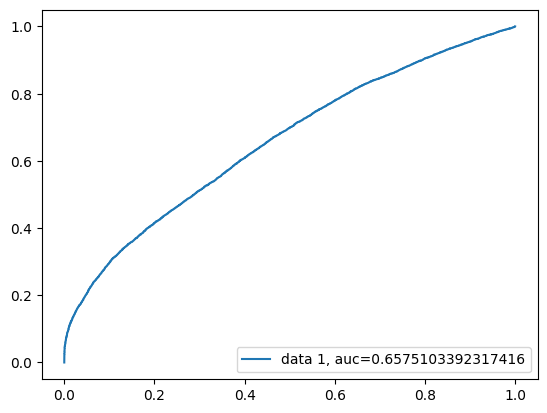

In [102]:
y_pred_proba = logreg.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Decision Tree

In [104]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_val)


In [105]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))


Accuracy: 0.777587228337127


In [112]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=12)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_val)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_val, y_pred))
print("F1:", metrics.f1_score(y_val, y_pred))
print("‘precision’:", metrics.precision_score(y_val, y_pred))



Accuracy: 0.8241090081381934
F1: 0.7849327080712188
‘precision’: 0.8545575294703636


In [111]:
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   no damage       0.81      0.90      0.85     17888
     damaged       0.85      0.73      0.79     14183

    accuracy                           0.82     32071
   macro avg       0.83      0.81      0.82     32071
weighted avg       0.83      0.82      0.82     32071



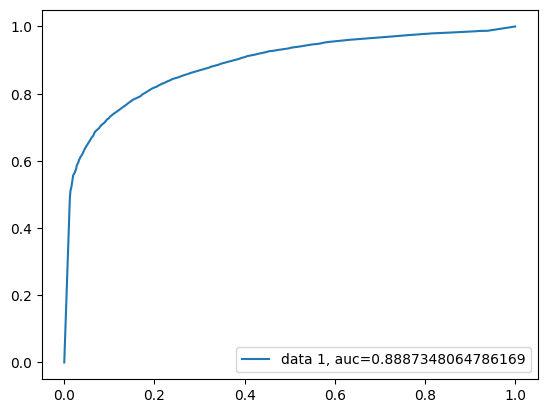

In [114]:
y_pred_proba = clf.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Random Forest

In [116]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [117]:
y_pred = rf.predict(X_val)

In [120]:
f1 = metrics.f1_score(y_val, y_pred)
print("f1_score:", f1)

f1_score: 0.8147671823580587


Hyperparameter Tuning

In [121]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000161E0518AC0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000161E054BCD0>})

In [122]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 254}


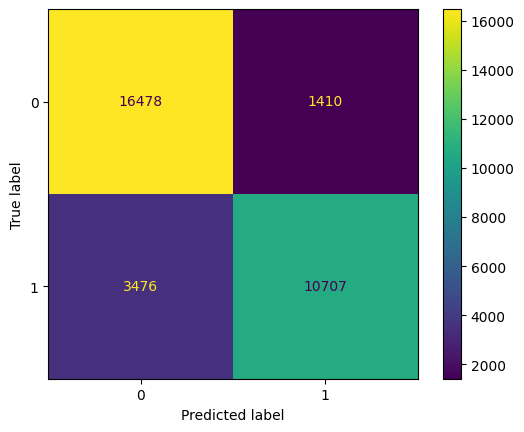

In [123]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_val)

# Create the confusion matrix
cm = confusion_matrix(y_val, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [126]:
y_pred = best_rf.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.8476505253967759
Precision: 0.8836345630106462
Recall: 0.7549178594091518
F1: 0.8142205323193916


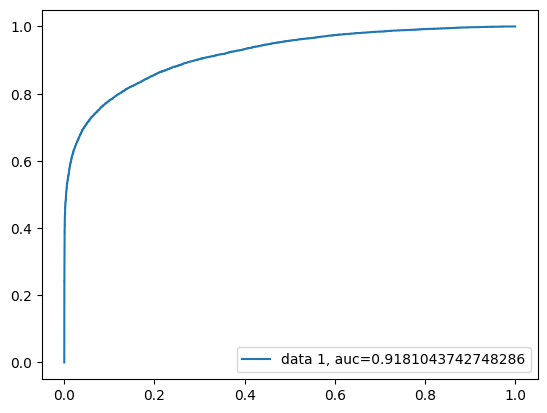

In [129]:
y_pred_proba = best_rf.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Feature Importance

<AxesSubplot:>

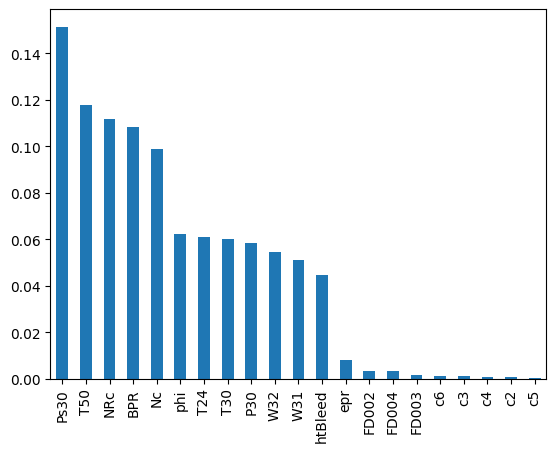

In [127]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

### CatBoost Classifier

documentation: https://catboost.ai/en/docs/concepts/python-quickstart

In [132]:
model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)
# train the model
model.fit(X_train,y_train)
# make the prediction using the resulting model
preds_class = model.predict(X_val)
preds_proba = model.predict_proba(X_val)
print("class = ", preds_class)
print("proba = ", preds_proba)

0:	learn: 0.6051164	total: 204ms	remaining: 204ms
1:	learn: 0.5622906	total: 240ms	remaining: 0us
class =  [1 1 0 ... 1 0 1]
proba =  [[0.4861692  0.5138308 ]
 [0.07854352 0.92145648]
 [0.70468841 0.29531159]
 ...
 [0.4861692  0.5138308 ]
 [0.82475588 0.17524412]
 [0.4861692  0.5138308 ]]


In [133]:
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   no damage       0.83      0.92      0.87     17888
     damaged       0.88      0.75      0.81     14183

    accuracy                           0.85     32071
   macro avg       0.85      0.84      0.84     32071
weighted avg       0.85      0.85      0.85     32071



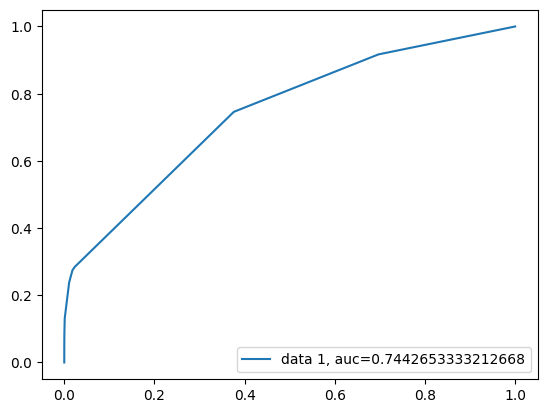

In [134]:
y_pred_proba = model.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### LightGBM Classifier

documentation:
 
    https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

    https://www.projectpro.io/recipes/use-lightgbm-classifier-and-regressor-in-python

In [138]:
ltb = LGBMClassifier()
ltb.fit(X_train, y_train)
print(); print(ltb)


LGBMClassifier()


In [139]:
y_pred = ltb.predict(X_val)

In [140]:
print("Accuracy:", metrics.accuracy_score(y_val, y_pred))
print("F1:", metrics.f1_score(y_val, y_pred))
print("‘precision’:", metrics.precision_score(y_val, y_pred))

Accuracy: 0.8466527392348228
F1: 0.8141204928566029
‘precision’: 0.8773930753564155


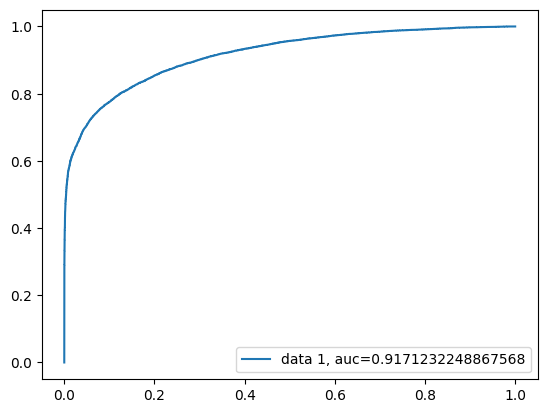

In [141]:
y_pred_proba = ltb.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Text(0.5, 427.9555555555555, 'Predicted label')

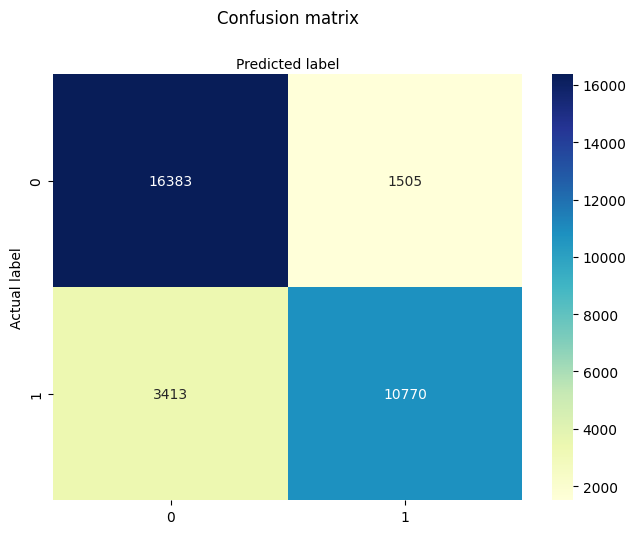

In [143]:
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')